In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, get_scorer_names, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, make_scorer, fbeta_score, roc_auc_score, roc_curve, matthews_corrcoef, balanced_accuracy_score, average_precision_score
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression

# missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ttest
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, f_oneway

from scipy.stats import randint, uniform

# rmse
from statsmodels.tools.eval_measures import rmse, mse

# Binning
from sklearn.preprocessing import KBinsDiscretizer

# Imbalanced
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# polynominal features
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpl

# Cross validation
from sklearn.model_selection import cross_val_score, cross_validate

# hypermarameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Ensemble Various type
from sklearn.ensemble import VotingClassifier, VotingRegressor, StackingClassifier, StackingRegressor, BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor

# Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder as OrdEnc
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost.sklearn import XGBClassifier, XGBRegressor

from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# Plot Importance
from xgboost import plot_importance

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# LGBM
import lightgbm as lgb

# from sklearn.inspection import plot_partial_de

import shap

# Optuna for hyperparameter tuning
import optuna

# Save
import pickle

# **Hotel Booking Demand**

By: Radithya Zuhayr Fasya

## **1. Business Problem**

### **1.1. Context**

Sebuah perusahaan yang bergerak di bidang perhotelan yang berlokasi di portugal ingin mengetahui customer mana yang berpotensi untuk membatalkan pemesanan kamar hotel. Perusahaan mendapatkan banyak sekali turis yang datang dari dalam negeri, maupun luar negeri yang menetap di kamar hotel yang telah disediakan. Namun tidak semua customer yang sudah memesan kamar hotel akan jadi menetap dan tinggal di sana. Ada juga beberapa customer yang membatalkan pemesanan. Untuk itu diperlukan model machine learning untuk memprediksi dengan benar apakah customer tersebut akan membatalkan pemesanan atau tidak berdasarkan informasi-informasi mengenai reservasi kamar untuk masing-masing customer.

### **1.2. Problem Statement**

Jika menggunakan strategi overbooking, maka diperlukan machine learning yang dapat memprediksi dengan baik. Karena jika kita tidak memiliki machine learning yang baik, maka strategi overbooking tidak akan berjalan dengan optimal. Overbooking yang seharusnya bisa menjadi strategi alternatif ketika customer tersebut berpotensi untuk tidak jadi menginap, malah jadi malapetaka karena sebenarnya customer tersebut tidak jadi membatalkan. Akibatnya, akan ada lebih dari satu customer yang memesan kamar yang sama di waktu yang sama.

Hal tersebut akan berdampak buruk terhadap perusahaan karena ketidakjelasan pemesanan yang redundant.

### **1.3. Goals**

Berikut adalah beberapa tujuan mengembangkan machine learning: 
- Meminimalisir terjadinya kesalahan prediksi.
- Mengoptimalkan strategi overbooking.

### **1.4 Analytic Approach**

Data Imbalance: 
- Customer yang tidak membatalkan pemesanan (0) memiliki jumlah proporsi yang lebih besar dibandingkan dengan yang membatalkan peemsanan (1).
- Solusinya adalah dengan menggunakan f1_score atau fbeta_score yang telah dikalkulasi antara FP dan FN.
- Saya juga akan mempertimbangkan untuk mentuning oversampling seperti RandomOvesampling dan SMOTE, serta undersampling seperti RandomUnderSampling dan NearMiss.

Model yang digunakan: 
- Karena saya ingin mencari model mana yang paling tinggi score fbeta nya, maka saya akan menggunakan semua model untuk di cross validation, dan akan ada 2 terbaik yang saya pilih untuk di hyperparameter tuning, dan dicari model mana yang menghasilkan paling sedikit kerugian.

### **1.5. Metrics Evaluation**

Target = `is_canceled`

- 0 = Reservasi tidak dibatalkan
- 1 = Reservasi dibatalkan

False Positive (FP): Model memprediksi pemesanan akan dibatalkan (1), padahal aslinya tidak dibatalkan (0).

- Perusahaan akan melakukan overbooking (akan menjual kamar yang sebenarnya sudah disewa, tapi karena customer tersebut diprediksi akan membatalkan pemesanan oleh sistem, maka sistem mengira bahwa kamar tersebut belum disewa). 
- Hal itu bisa menyebabkan kehilangan kepercayaan terhadap perusahaan kami.
- Kalau misalnya customer tersebut merupakan tokoh terkenal, reputasi customer akan menjadi buruk.
- Customer tersebut berpindah ke hotel lain.  
- Cost:
  - Asumsikan bahwa 50% customer mendapatkan kompensasi sebesar 50% dari rata-rata harga kamar per malam yaitu 124 euro
  - Cost: 0.5 * 124 = 62 euro
  - Biaya untuk memperbaiki loyalitas customer: 50 euro
  - Total: 112 euro

False Negative (FN): Model memprediksi pemesanan tidak akan dibatalkan (0), padahal aslinya dibatalkan (1).

- Pihak hotel akan kehilangan customer jika diprediksi tidak membatalkan, padahal aslinya membatalkan.
- Bedanya dengan FP, yang membatalkan ialah pihak customer. Bukan pihak hotel. 
- Akan tetapi, pihak hotel tidak perlu takut untuk kehilangan kepercayaan, karena yang membatalkan ialah customer dengan banyak pertimbangan. Karena pastinya customer mempunyai alasan yang jelas untuk membatalkan pemesanan.
- Perusahaan masih bisa mengatasi ini dengan strategi last-minute booking. Untuk dari itu, kita kesampingkan cost ketika kehilangan customer.
  - Cost:
  - Asumsikan bahwa 50% customer mendapatkan kompensasi sebesar 50% dari rata-rata harga kamar per malam yaitu 124 euro
  - Cost: 0.5 * 124 = 62 euro

Dari dampak bisnis diatas, dapat terlihat bahwa False Positive (FP) memiliki dampak kerugian yang besar. Karena dampak buruk yang diberikan setelah melakukan overbooking. Maka scoring yang digunakan adalah f0.76, f1, dan roc_auc.

### **1.6. Data Understanding**

### Deskripsi Kolom dalam Dataset

| **Kolom**                     | **Deskripsi**                                                                                                                    |
| ----------------------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| `country`                     | Negara asal pelanggan.                                                                                                           |
| `market_segment`              | Segmen pasar dari pemesanan (misalnya Online TA, Offline TA/TO, Direct).                                                         |
| `previous_cancellations`      | Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.                                           |
| `booking_changes`             | Jumlah perubahan/amandemen yang dilakukan pada pemesanan sejak pemesanan dimasukkan ke PMS hingga saat check-in atau pembatalan. |
| `deposit_type`                | Jenis deposit yang digunakan (No Deposit, Non Refund, Refundable).                                                               |
| `days_in_waiting_list`        | Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan.                                          |
| `customer_type`               | Jenis pelanggan berdasarkan pola pemesanannya (misalnya Transient, Contract, Group).                                             |
| `reserved_room_type`          | Tipe kamar yang awalnya dipesan pelanggan. (Berbentuk kode karena demi alasan anonimitas)                                        |
| `required_car_parking_spaces` | Jumlah tempat parkir yang diminta oleh pelanggan.                                                                                |
| `total_of_special_requests`   | Jumlah permintaan khusus dari pelanggan (misalnya tambahan bantal, kamar di lantai tertentu).                                    |
| `is_canceled`                 | Status pembatalan pemesanan (0 = Tidak Dibatalkan, 1 = Dibatalkan).                                                              |


In [60]:
df = pd.read_csv('dataset/data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


## **2. Data Cleaning**


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [62]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

In [63]:
df.isna().sum() / len(df) * 100

country                        0.419992
market_segment                 0.000000
previous_cancellations         0.000000
booking_changes                0.000000
deposit_type                   0.000000
days_in_waiting_list           0.000000
customer_type                  0.000000
reserved_room_type             0.000000
required_car_parking_spaces    0.000000
total_of_special_requests      0.000000
is_canceled                    0.000000
dtype: float64

In [64]:
df[(df['country'].isna()) | (df['market_segment'] == 'Undefined')]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
814,NaN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1166,NaN,Direct,2,0,No Deposit,0,Transient,E,0,3,1
1304,NaN,Direct,0,1,No Deposit,0,Transient,D,0,1,0
1661,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
2182,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
82466,NaN,Offline TA/TO,0,0,No Deposit,0,Transient,A,0,0,0
83084,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
83106,NaN,Direct,0,0,No Deposit,0,Transient,A,0,2,0
83353,NaN,Direct,0,0,No Deposit,0,Transient,A,0,0,0


hanya 0.4% dari total data yang merupakan data NaN. ada beberapa opsi untuk menanganinya.

- Opsi: Bisa menghapusnya, karena hanya 0.4% dari total data yang artinya tidak signifikan.

Kita coba opsi yang kedua


In [65]:
df['market_segment'] = np.where(
    df['market_segment'] == 'Undefined', np.nan, df['market_segment'])

In [66]:
df.dropna(inplace=True)

In [67]:
df.duplicated().sum()

np.int64(73138)

In [68]:
# Cek jumlah duplikasi di seluruh kolom
duplicate_rows = df[df.duplicated()]
print(f"Jumlah baris duplikat: {duplicate_rows.shape[0]}")

# Cek persentase data duplikat
percentage = (duplicate_rows.shape[0] / df.shape[0]) * 100
print(f"Persentase duplikasi: {percentage:.2f}%")

Jumlah baris duplikat: 73138
Persentase duplikasi: 87.88%


In [69]:
df[df.duplicated]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
22,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
29,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
34,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
44,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


Terdapat 73138 data yang duplikasi (87.88%) dari total data sebanyak 83221. Karena pada dataset ini hanya sebelas kolom, dan tidak ada kolom tanggal reservasi, checkout, dan lain-lain yang dapat menjadi pembeda antara data baris duplikat dengan data duplikat lainnya, maka saya asumsikan data duplikat ini tidak memberikan informasi tambahan. Maka bisa di drop.


In [70]:
df.drop_duplicates(inplace=True)

In [71]:
pd.set_option('display.max_colwidth', 10000)

# data unit di tiap kolom
listItem = []
for col in df.columns:
    listItem.append([col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                          data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,country,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, SVK, ...]"
1,market_segment,7,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


In [72]:
df.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

Mengecek apakah ada kesalahan penulisan dalam dataframe


In [73]:
pd.DataFrame(df, columns=["hotel", "arrival_date_month", "arrival_date_year", "country", "market_segment",
             "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "reservation_status"])

for col in df:

    print(col, df[col].unique())

country ['IRL' 'FRA' 'PRT' 'NLD' 'ESP' 'UMI' 'CN' 'LUX' 'BRA' 'BEL' 'JPN' 'DEU'
 'ITA' 'CHE' 'GBR' 'AGO' 'SRB' 'COL' 'CHN' 'SWE' 'AUT' 'CIV' 'CZE' 'POL'
 'USA' 'SGP' 'RUS' 'ROU' 'DNK' 'IND' 'MAR' 'PHL' 'ARG' 'ISL' 'ZAF' 'LBN'
 'MOZ' 'TUR' 'BGD' 'MEX' 'CAF' 'NOR' 'FIN' 'UKR' 'EGY' 'ISR' 'KOR' 'AZE'
 'HUN' 'AUS' 'EST' 'CHL' 'SVN' 'PRY' 'ABW' 'ALB' 'LTU' 'ARE' 'HRV' 'SAU'
 'NZL' 'LVA' 'ATA' 'KAZ' 'DZA' 'TWN' 'CRI' 'BIH' 'BGR' 'IRQ' 'OMN' 'VEN'
 'IDN' 'GEO' 'MLT' 'IRN' 'BLR' 'URY' 'LBY' 'TUN' 'BEN' 'MYS' 'MWI' 'GRC'
 'CYP' 'CPV' 'HKG' 'PRI' 'MKD' 'MUS' 'IMN' 'PAN' 'NGA' 'GLP' 'KHM' 'PER'
 'QAT' 'SEN' 'MAC' 'SVK' 'BHR' 'ECU' 'SYC' 'BOL' 'TJK' 'LCA' 'MDV' 'SYR'
 'ZMB' 'LIE' 'THA' 'MNE' 'BRB' 'CMR' 'JEY' 'GTM' 'LKA' 'JOR' 'TZA' 'AND'
 'ARM' 'GIB' 'VNM' 'PAK' 'JAM' 'DOM' 'KWT' 'LAO' 'RWA' 'FRO' 'GAB' 'ETH'
 'CUB' 'COM' 'GNB' 'GGY' 'NIC' 'TGO' 'TMP' 'CYM' 'GHA' 'SLE' 'BWA' 'NCL'
 'UZB' 'SUR' 'SDN' 'PLW' 'MLI' 'MMR' 'BFA' 'SLV' 'BDI' 'ZWE' 'UGA' 'DMA'
 'VGB' 'KIR' 'KEN' 'MYT' 'KNA' 'AIA']
market

## **3. EDA**


In [74]:
categorical_cols = list(df.select_dtypes(['object', 'category']).columns)
numerical_cols = list(
    set(df.drop('is_canceled', axis=1).columns)-set(categorical_cols))

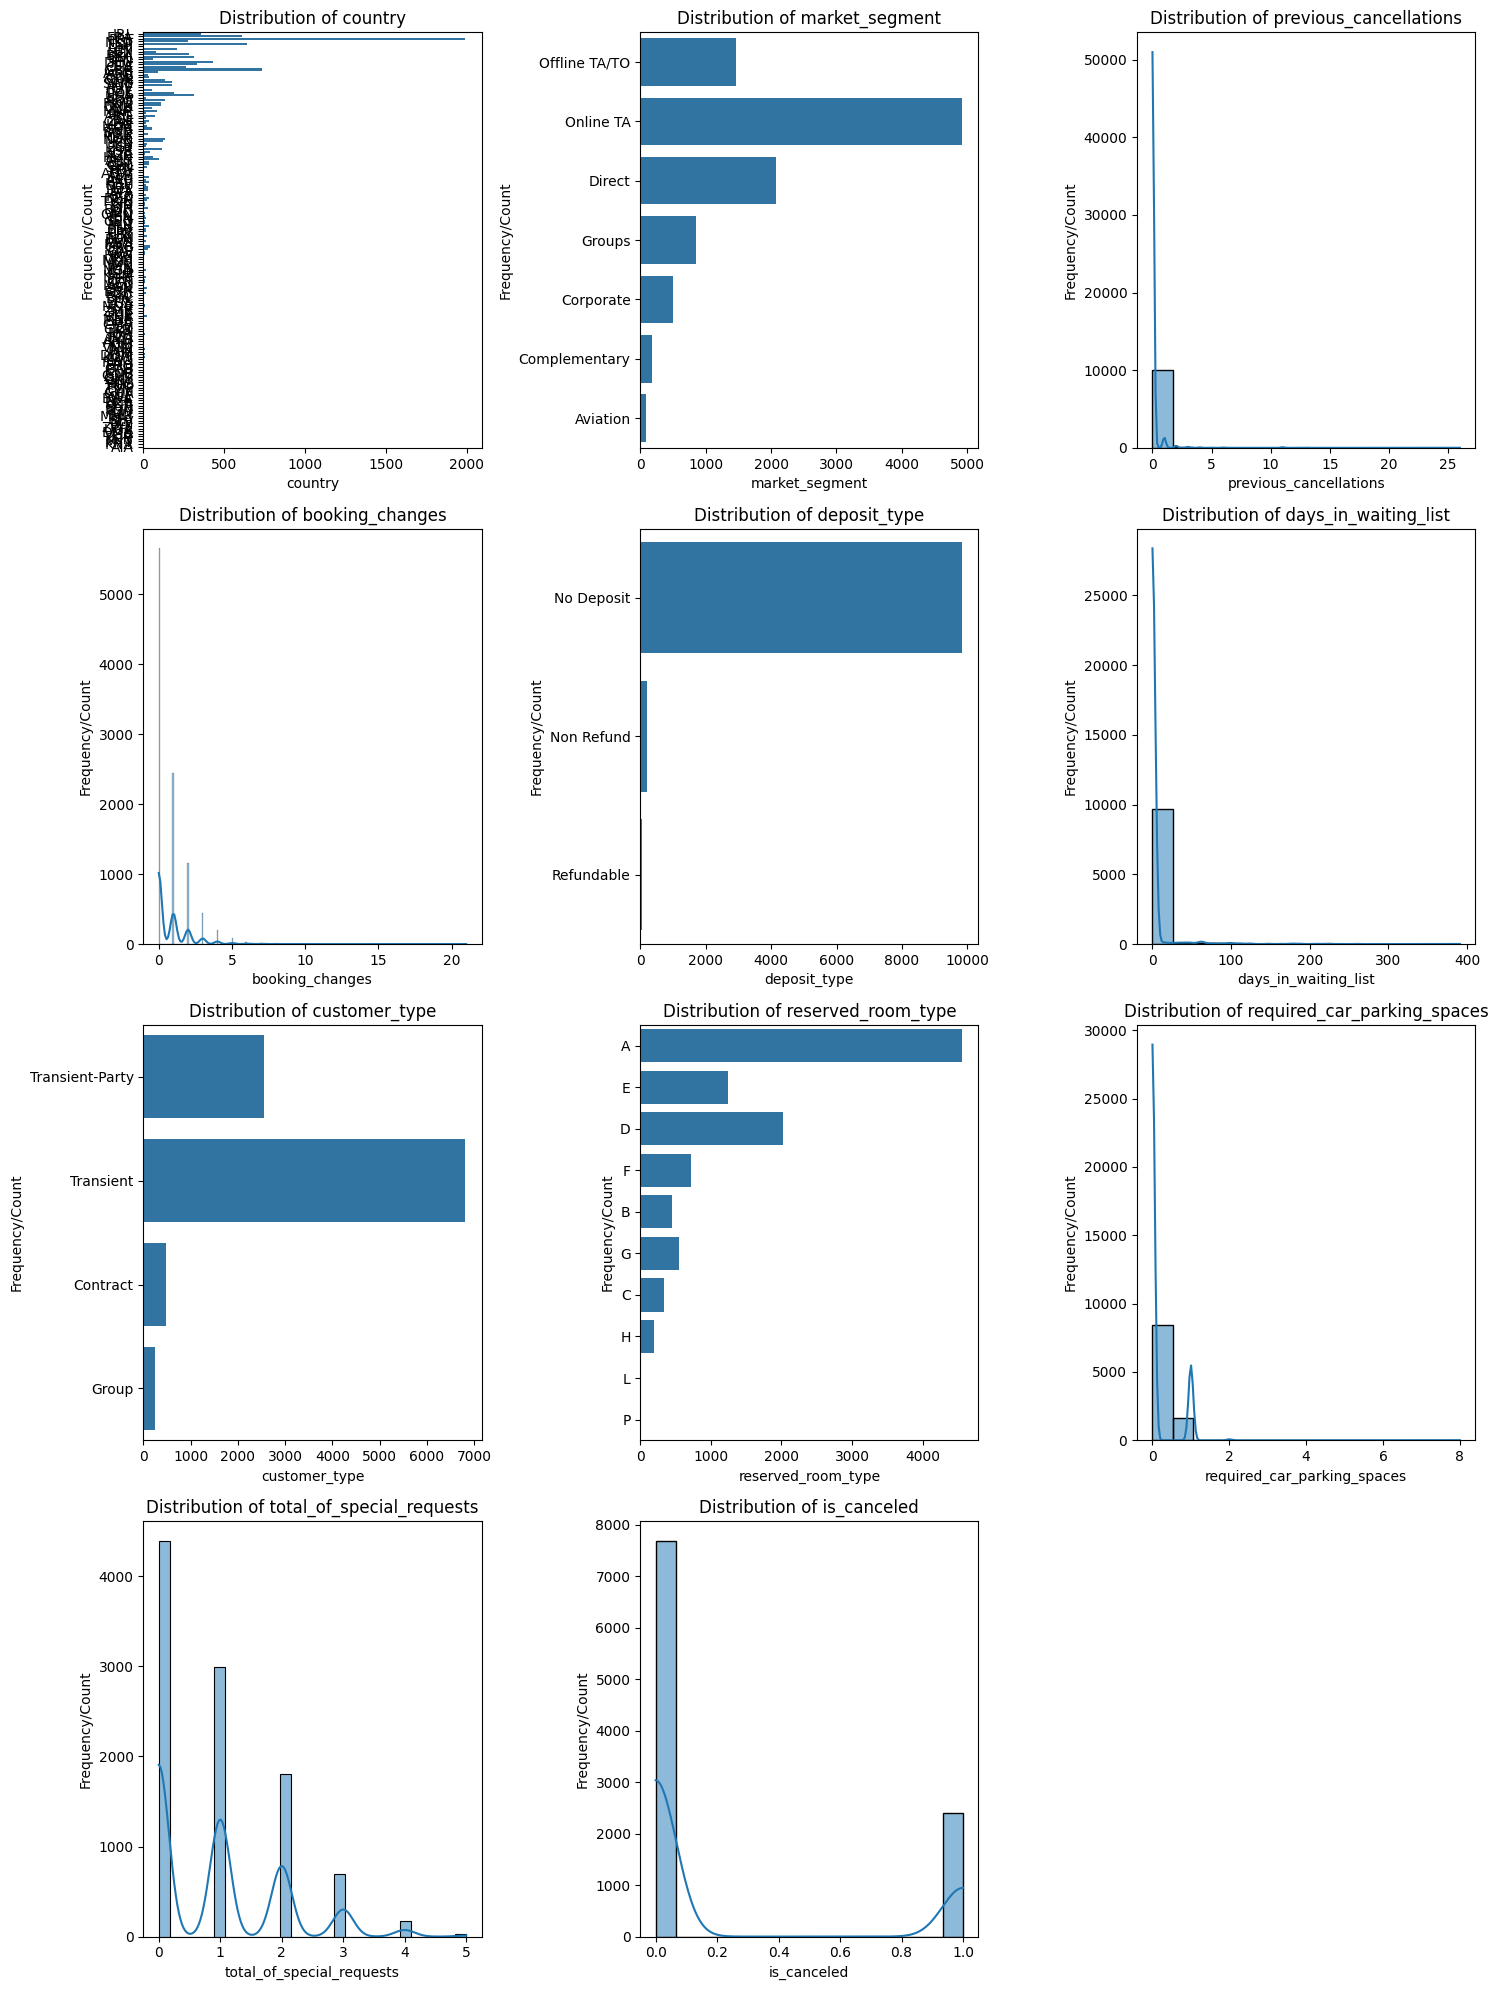

In [75]:
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3
plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(df.columns):
    plt.subplot(num_rows, 3, i + 1)
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], kde=True)
    else:
        sns.countplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency/Count')

plt.tight_layout()
plt.show()

In [76]:
df[df['customer_type'] == 'Group']

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
422,IRL,Online TA,0,0,No Deposit,0,Group,A,0,2,0
427,FRA,Offline TA/TO,0,0,No Deposit,0,Group,D,0,0,0
788,PRT,Direct,0,0,No Deposit,0,Group,A,0,1,0
835,PRT,Direct,0,1,No Deposit,0,Group,E,0,0,0
1258,ISR,Groups,0,0,No Deposit,0,Group,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
81566,ITA,Offline TA/TO,0,0,No Deposit,0,Group,D,0,1,0
82185,PRT,Online TA,0,0,No Deposit,0,Group,A,0,2,0
82267,MEX,Direct,0,0,No Deposit,0,Group,A,0,0,0
82289,USA,Online TA,0,0,No Deposit,0,Group,A,0,2,0


In [77]:
df.groupby(['customer_type', 'market_segment']).size().unstack()

market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA
customer_type,,,,,,,
Contract,NaN,NaN,9.0,9.0,17.0,161.0,285.0
Group,1.0,2.0,12.0,61.0,8.0,66.0,91.0
Transient,71.0,163.0,268.0,1663.0,199.0,700.0,3749.0
Transient-Party,9.0,15.0,216.0,346.0,621.0,542.0,799.0


In [78]:

top10_country = df['country'].value_counts().to_frame().reset_index().head(10)
top10_country = top10_country.rename(
    columns={'country': 'Number of Bookings', 'index': 'Country'})
top10_country

,Number of Bookings,count
0,PRT,1992
1,GBR,734
2,ESP,641
3,FRA,612
4,DEU,432
5,IRL,355
6,ITA,329
7,BEL,312
8,USA,310
9,BRA,285


<Axes: xlabel='Number of Bookings', ylabel='count'>

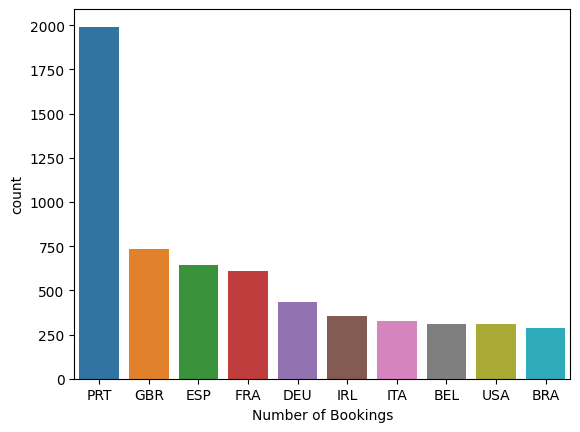

In [79]:
sns.barplot(data=top10_country, x='Number of Bookings',
            y='count', hue='Number of Bookings')

Mari kita cek hubungan kolom-kolom dengan target (is_canceled)

days_in_waiting_list --> Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.
- Artinya

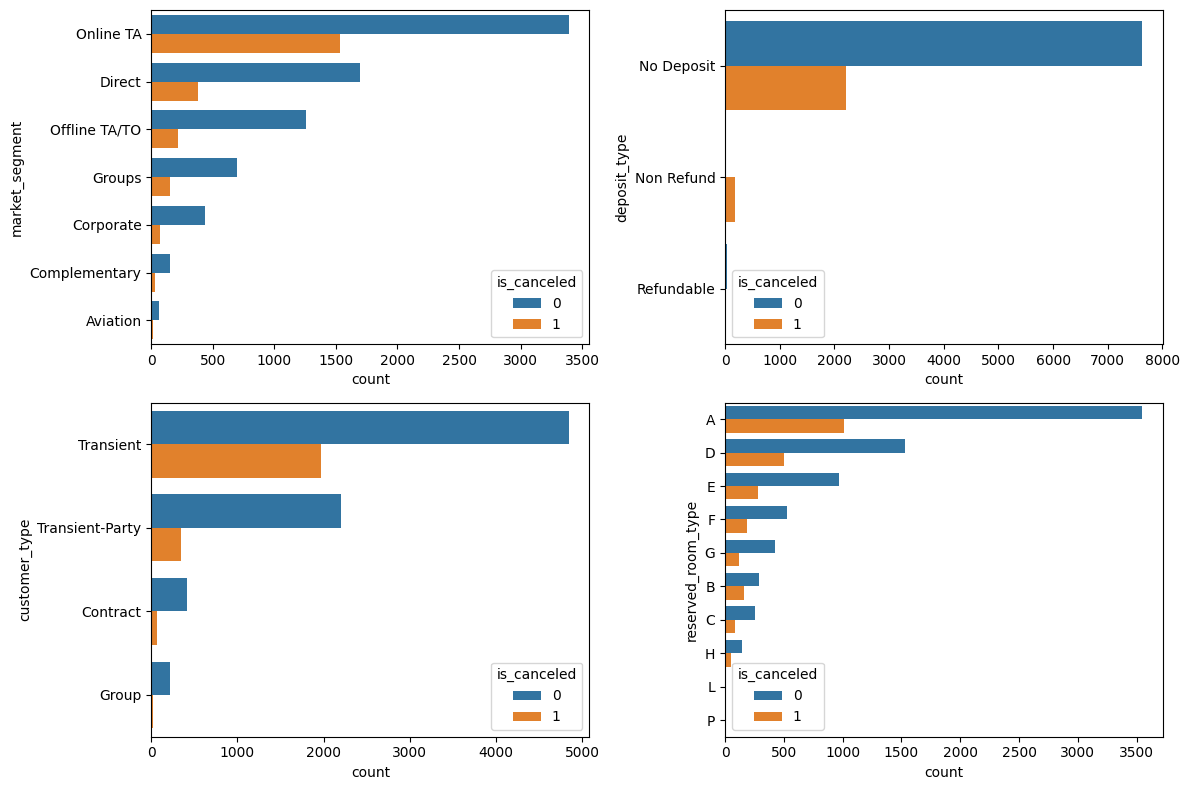

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, j in zip([cols for cols in categorical_cols if cols != 'country'], axes.flatten()):
    sns.countplot(data=df, y=i, ax=j, hue='is_canceled',
                  order=df[i].value_counts().index)

plt.tight_layout()

plt.show()

<Axes: xlabel='count', ylabel='country'>

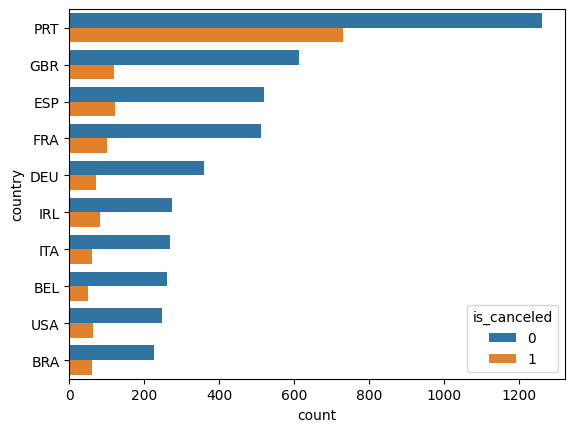

In [81]:
df_country = df[df['country'].isin(top10_country['Number of Bookings'])]

sns.countplot(data=df_country, y='country', hue='is_canceled',
              order=df_country['country'].value_counts().index)

In [82]:
df['is_canceled'].value_counts() / len(df)

is_canceled
0    0.762471
1    0.237529
Name: count, dtype: float64

<Axes: xlabel='is_canceled', ylabel='count'>

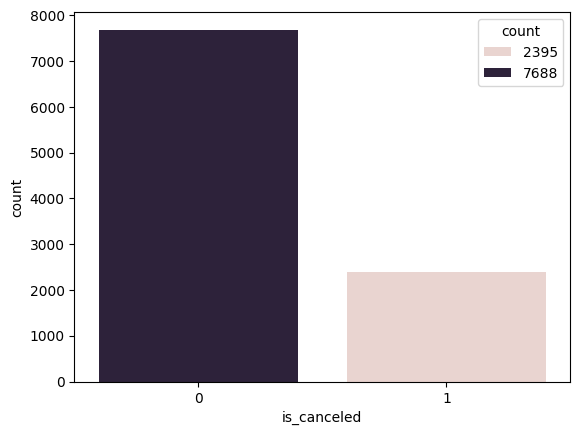

In [83]:
canceled = pd.DataFrame(df['is_canceled'].value_counts()).reset_index()

sns.barplot(data=canceled, x='is_canceled', y='count', hue='count')

Dapat terlihat bahwa data merupakan imbalanced alias tidak seimbang.


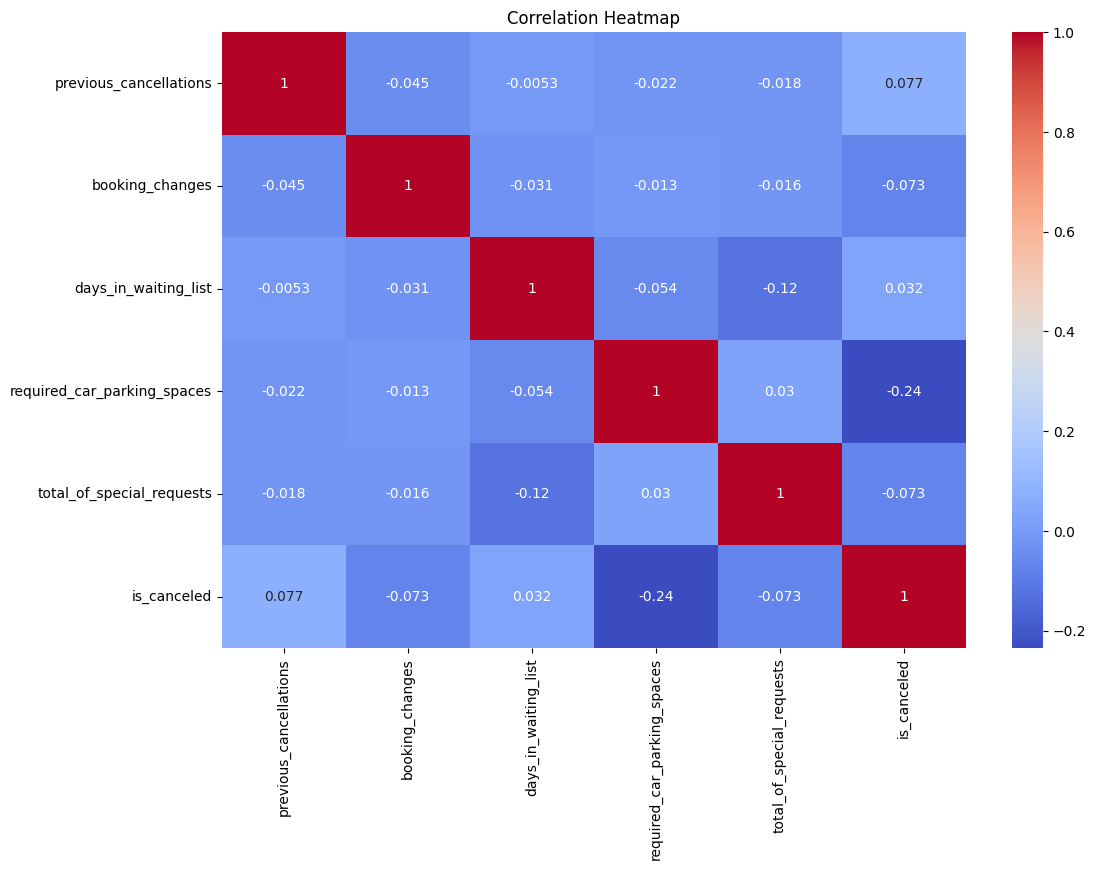

In [84]:
# Correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Sekarang, mari kita analisis customer mana saja yang cancel / tidak cancel berdasarkan kolom lain.


Berdasarkan Negara Asal:


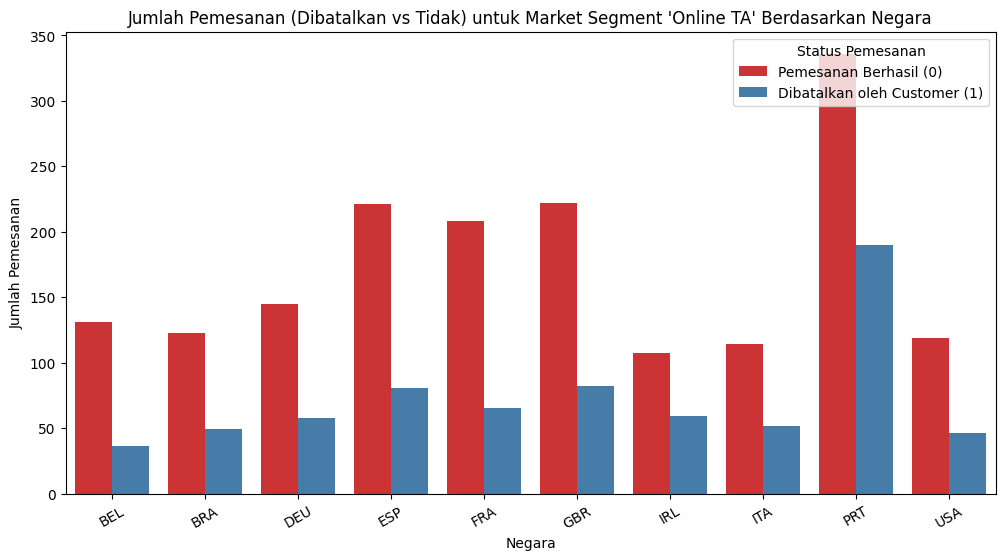

In [85]:
# 1. Filter hanya untuk market_segment = 'Online TA'
df_online_ta = df[df["market_segment"] == "Online TA"]

# 2. Hitung jumlah pemesanan berdasarkan negara & status pembatalan
country_cancel = df_online_ta.groupby(["country", "is_canceled"])[
    "is_canceled"].count().reset_index(name="counts")

# 3. Ambil 10 negara dengan jumlah pemesanan terbanyak
top_10_countries = country_cancel.groupby(
    "country")["counts"].sum().nlargest(10).index
country_cancel = country_cancel[country_cancel["country"].isin(
    top_10_countries)]

# 4. Pilih warna palet
# Ambil 2 warna untuk kategori is_canceled
colors = sns.color_palette("Set1", n_colors=2)

# 5. Buat barplot dengan warna yang sesuai
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=country_cancel, x="country", y="counts",
                 hue="is_canceled", palette=colors)

# 6. Tambahkan label dan judul
plt.title("Jumlah Pemesanan (Dibatalkan vs Tidak) untuk Market Segment 'Online TA' Berdasarkan Negara", fontsize=12)
plt.xlabel("Negara")
plt.ylabel("Jumlah Pemesanan")

# 7. Perbaiki legend agar warnanya sama dengan barplot
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=[
           "Pemesanan Berhasil (0)", "Dibatalkan oleh Customer (1)"], title="Status Pemesanan", loc="upper right")

# 8. Rotate label sumbu x agar lebih mudah dibaca
plt.xticks(rotation=30)

# 9. Tampilkan plot
plt.show()

In [86]:
df['country'].value_counts()

country
PRT    1992
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
DMA       1
KIR       1
MYT       1
KNA       1
AIA       1
Name: count, Length: 162, dtype: int64

Negara portugal adalah yang tertinggi. Karena kebanyakan customer berasal dari dalam negeri. Karena memang lokasi hotelnya berada di negara portugal.

Untuk lebih detail, mari kita cek proporsi untuk negara portugal.


In [87]:
df[df['country'] == 'PRT'][['is_canceled']].value_counts()

is_canceled
0              1261
1               731
Name: count, dtype: int64

Dapat terlihat bahwa proporsi yang tidak membatalkan dan yang membatalkan berdasarkan negara tidak berpengaruh, karena walaupun di luar negara portugal, atau negara-negara yang jauh dari portugal pun jumlah customer yang tidak membatalkan lebih besar dibandingkan dengan yang membatalkan pemesanan dari segi proporsi.


Berdasarkan Market_segment:


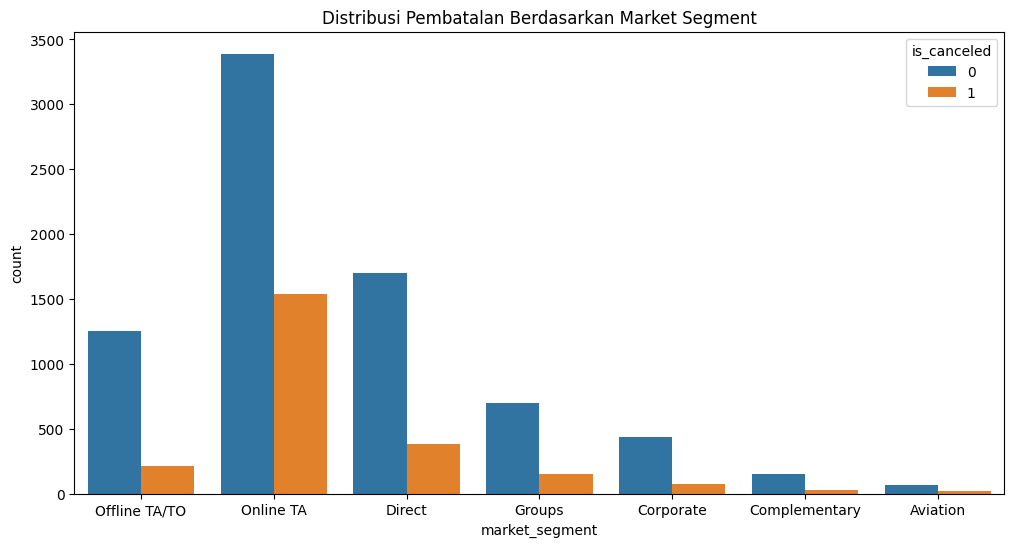

In [88]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='market_segment', hue="is_canceled")
plt.title('Distribusi Pembatalan Berdasarkan Market Segment')
plt.show()

In [89]:
print(f"{round(df['market_segment'].value_counts() / len(df) * 100, 2)}")

market_segment
Online TA        48.83
Direct           20.62
Offline TA/TO    14.57
Groups            8.38
Corporate         5.01
Complementary     1.79
Aviation          0.80
Name: count, dtype: float64


In [90]:
df_OnTA = df[df['market_segment'] == 'Online TA'].groupby(
    by='is_canceled')[['country']].count().reset_index()

df_OnTA = df_OnTA.rename(columns={'country': 'counts'})
total = df_OnTA["counts"].sum()

df_OnTA['percentage'] = (df_OnTA["counts"] / total) * 100
df_OnTA

,is_canceled,counts,percentage
0,0,3390,68.846466
1,1,1534,31.153534


Berdasarkan market segment:

- Online TA: OTA memiliki tingkat pembatalan tertinggi. Tapi akan menjadi bias, karena memang kebanyakan customer memesan kamar hotel melalui aplikasi OTA.

Untuk itu, Mari kita lihat lebih detail dari customer yang memesan kamar hotel dengan pemesanan selain Online TA berdasarkan negara. Apakah negara berpengaruh terhadap peluang customer untuk membatalkan pemesanan?


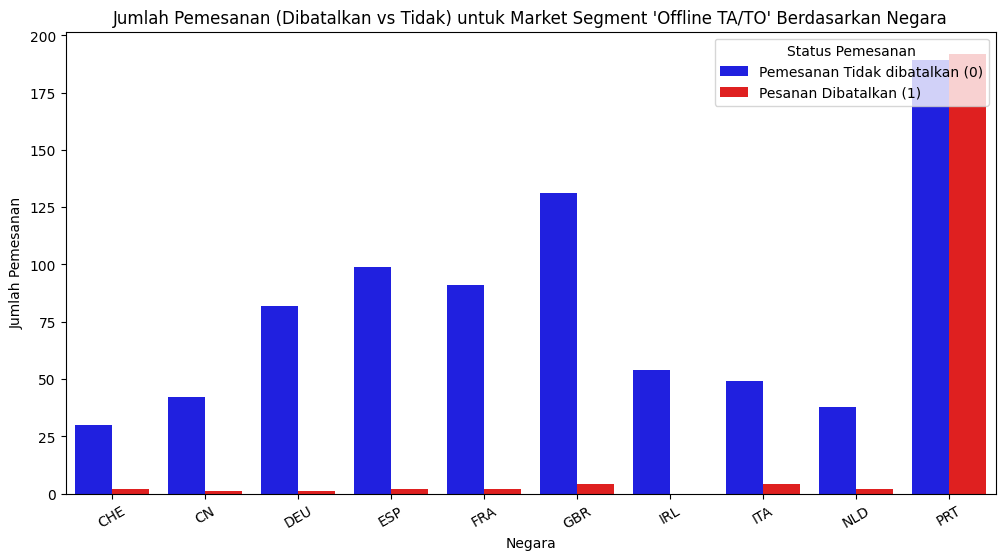

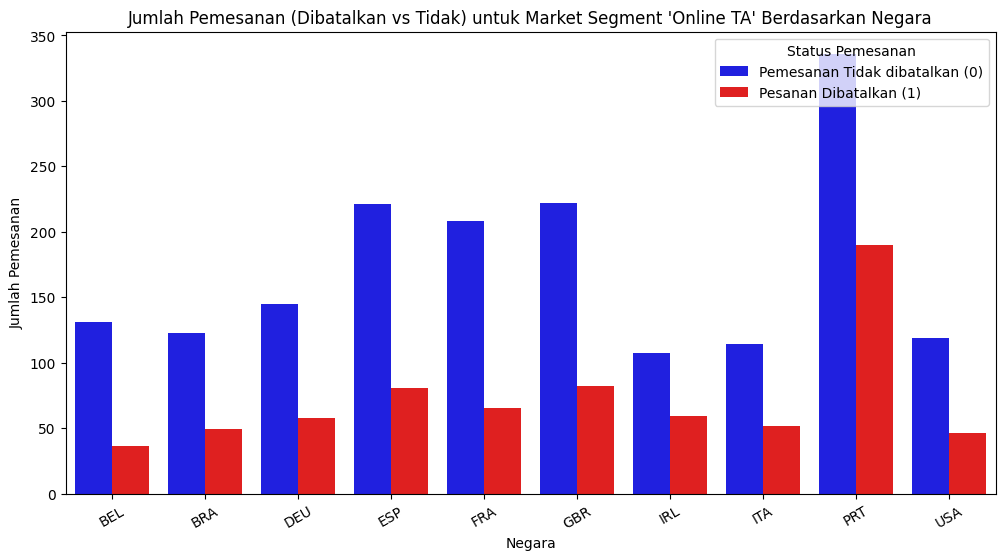

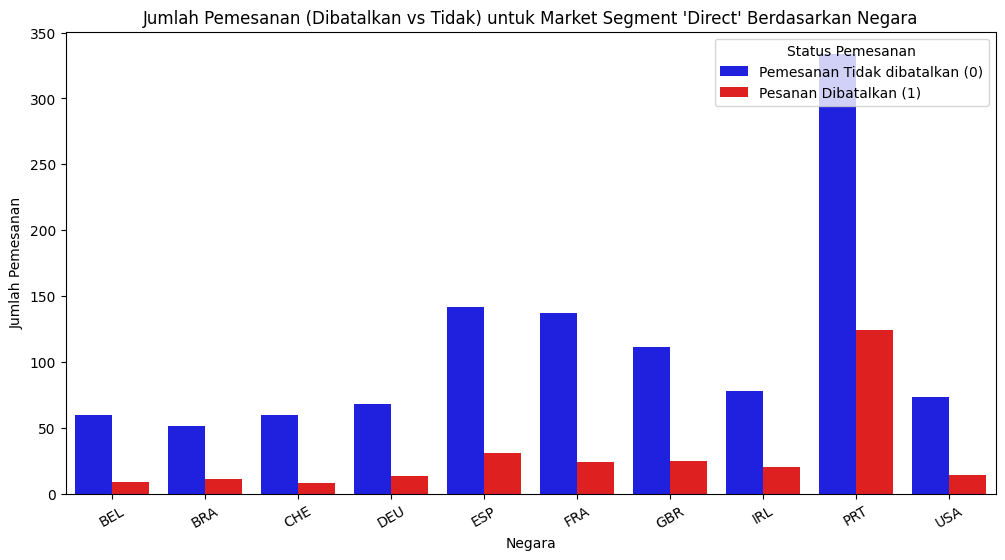

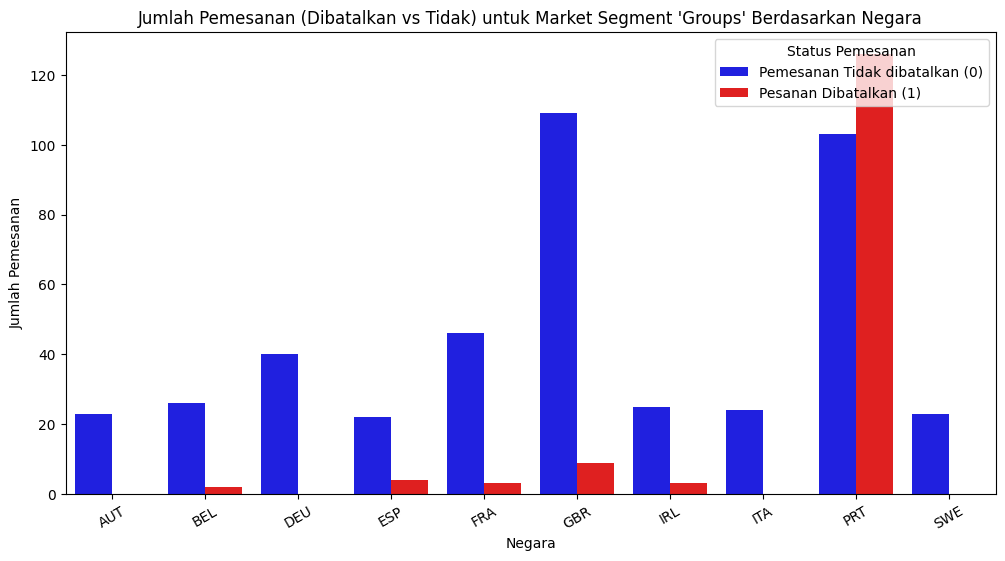

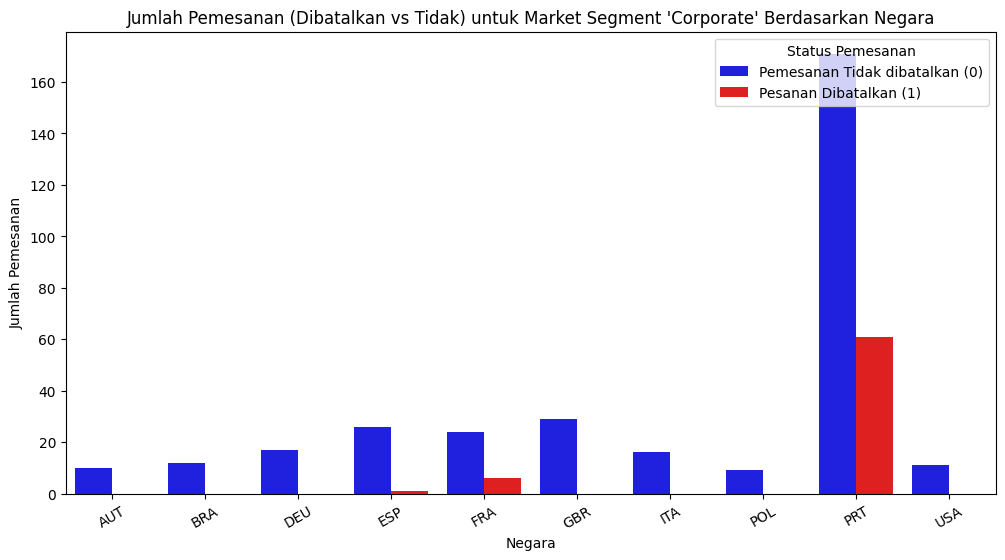

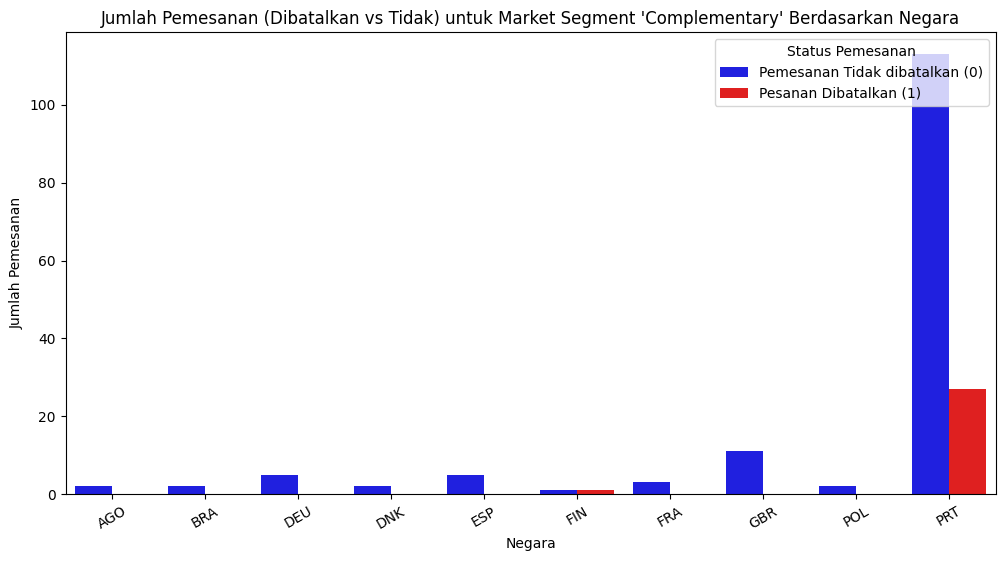

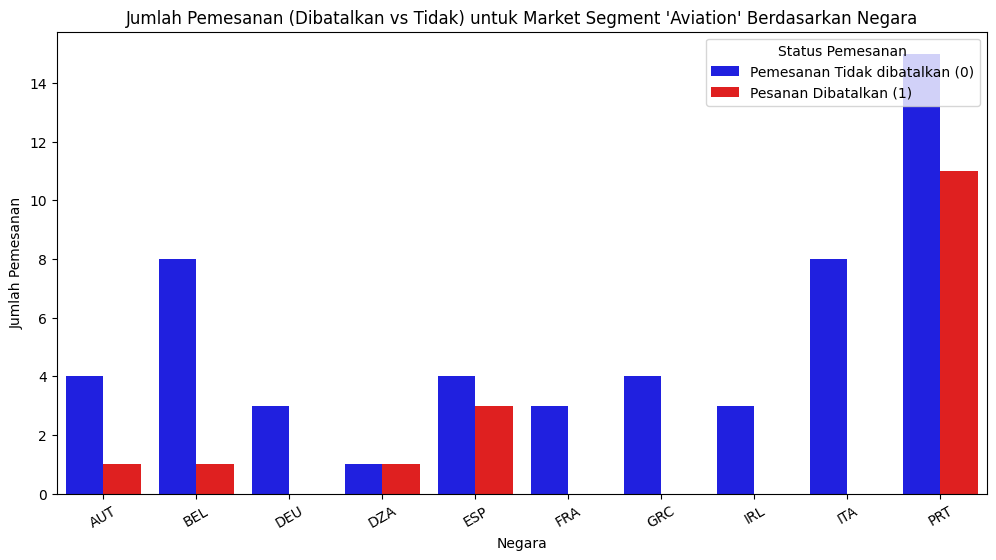

In [91]:
# Loop untuk setiap unique value dalam market_segment
for segment in df["market_segment"].unique():
    # 1. Filter berdasarkan market_segment
    df_segment = df[df["market_segment"] == segment]

    # 2. Hitung jumlah pemesanan berdasarkan negara & status pembatalan
    country_cancel = df_segment.groupby(["country", "is_canceled"])[
        "is_canceled"].count().reset_index(name="counts")

    # 3. Ambil 10 negara dengan jumlah pemesanan terbanyak
    top_10_countries = country_cancel.groupby(
        "country")["counts"].sum().nlargest(10).index
    country_cancel = country_cancel[country_cancel["country"].isin(
        top_10_countries)]

    # 4. Pilih warna (Merah untuk Dibatalkan, Biru untuk Berhasil)
    colors = {0: "blue", 1: "red"}  # 0 = Pemesanan Berhasil, 1 = Dibatalkan

    # 5. Buat barplot dengan warna yang sesuai
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=country_cancel, x="country",
                     y="counts", hue="is_canceled", palette=colors)

    # 6. Tambahkan label dan judul
    plt.title(
        f"Jumlah Pemesanan (Dibatalkan vs Tidak) untuk Market Segment '{segment}' Berdasarkan Negara", fontsize=12)
    plt.xlabel("Negara")
    plt.ylabel("Jumlah Pemesanan")

    # 7. Perbaiki legend agar warnanya sama dengan barplot
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Pemesanan Tidak dibatalkan (0)", "Pesanan Dibatalkan (1)"],
               title="Status Pemesanan", loc="upper right")

    # 8. Rotate label sumbu x agar lebih mudah dibaca
    plt.xticks(rotation=30)

    # 9. Tampilkan plot
    plt.show()

In [92]:
df[(df['country'] == 'DZA') & (df['market_segment']
                               == 'Aviation')][['is_canceled']].value_counts()

is_canceled
0              1
1              1
Name: count, dtype: int64

- Customer lokal (berasal dari portugal) yang memesan melalui Offline TA/TO dan untuk kelompok besar (Groups) lebih banyak yang membatalkan dibandingkan yang tidak membatalkan. Untuk itu, mari kita fokus kepada Customer lokal (berasal dari portugal) yang melalui Offline TA/TO atau untuk Kelompok Besar (Groups). Faktor apa saja yang mempengaruhi mereka untuk membatalkan pemesanan? Mari kita ulik lebih jauh dengan menghubungkan dengan kolom lainnya.


In [93]:
df[(df['country'] == 'PRT') & ((df['market_segment'] == 'Offline TA/TO')
                               | (df['market_segment'] == 'Groups')) & (df['is_canceled'] == 1)]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
6,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
9,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1
12,PRT,Groups,1,0,Non Refund,0,Transient,A,0,0,1
14,PRT,Offline TA/TO,0,0,Non Refund,3,Transient,A,0,0,1
23,PRT,Offline TA/TO,0,0,Non Refund,39,Transient,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
79278,PRT,Groups,0,0,Non Refund,76,Transient,D,0,0,1
79828,PRT,Groups,0,1,Non Refund,391,Transient,A,0,0,1
80081,PRT,Groups,0,0,Non Refund,56,Transient,A,0,0,1
81289,PRT,Offline TA/TO,0,1,No Deposit,0,Transient,C,0,1,1


In [94]:
df[(df['country'] == 'PRT') & ((df['market_segment'] == 'Offline TA/TO') | (df['market_segment']
                                                                            == 'Groups')) & (df['is_canceled'] == 1)]['previous_cancellations'].value_counts()

previous_cancellations
0     239
1      67
3       2
13      2
24      1
25      1
26      1
2       1
19      1
6       1
11      1
21      1
Name: count, dtype: int64

In [95]:
df[(df['country'] == 'PRT') & ((df['market_segment'] == 'Offline TA/TO') | (df['market_segment']
                                                                            == 'Groups')) & (df['is_canceled'] == 1)]['previous_cancellations'].value_counts()

previous_cancellations
0     239
1      67
3       2
13      2
24      1
25      1
26      1
2       1
19      1
6       1
11      1
21      1
Name: count, dtype: int64

In [96]:
df[(df['country'] == 'PRT') & ((df['market_segment'] == 'Offline TA/TO') | (df['market_segment'] == 'Groups')) & (df['is_canceled'] == 1)]['previous_cancellations'].value_counts() / \
    len(df[(df['country'] == 'PRT') & ((df['market_segment'] == 'Offline TA/TO') |
        (df['market_segment'] == 'Groups')) & (df['is_canceled'] == 1)]['previous_cancellations'])

previous_cancellations
0     0.751572
1     0.210692
3     0.006289
13    0.006289
24    0.003145
25    0.003145
26    0.003145
2     0.003145
19    0.003145
6     0.003145
11    0.003145
21    0.003145
Name: count, dtype: float64

In [97]:
df['previous_cancellations'].value_counts() / len(df)

previous_cancellations
0     0.962511
1     0.025488
2     0.005058
3     0.002281
11    0.001587
4     0.001091
6     0.000694
5     0.000298
13    0.000298
24    0.000198
25    0.000099
14    0.000099
26    0.000099
19    0.000099
21    0.000099
Name: count, dtype: float64

Dari segi proporsi tidak ada yang aneh. Cek kolom lainnya.


### Mengecek kolom `deposit_type`

Apakah kolom `deposit_type` memiliki hubungan dengan `is_canceled`?


In [98]:
df.groupby(by=['is_canceled', 'deposit_type'])[
    'is_canceled'].count().reset_index(name='counts')

,is_canceled,deposit_type,counts
0,0,No Deposit,7634
1,0,Non Refund,21
2,0,Refundable,33
3,1,No Deposit,2208
4,1,Non Refund,173
5,1,Refundable,14


Berdasarkan `deposit_type`:

- `deposit_type` = 'Non Refund' justru jenis deposit yang lebih sering membatalkan pemesanan kamar hotel dibandingkan tidak membatalkan.
- Hal ini cukup aneh, karena 'Non Refund' sendiri artinya adalah pengunjung membayar deposit di awal, tetapi tidak mendapatkan uang kembali jika pesanan dibatalkan.

Coba kita bedah lagi untuk tipe deposit 'Non Refund' berdasarkan negara.


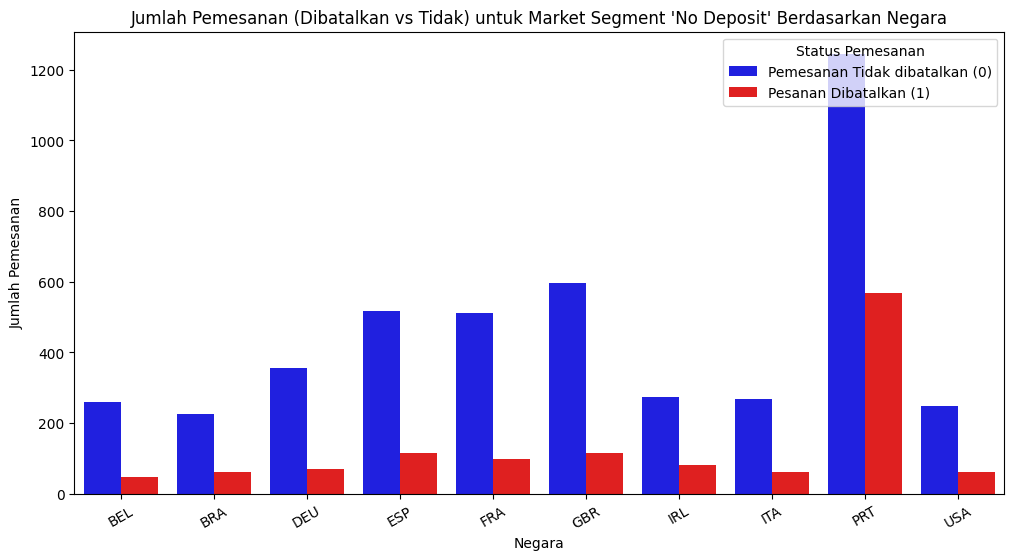

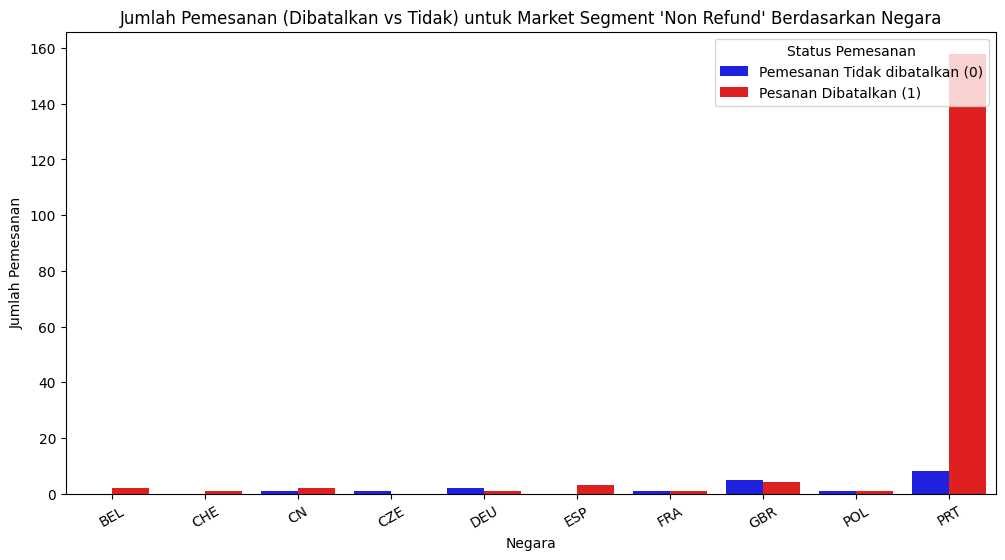

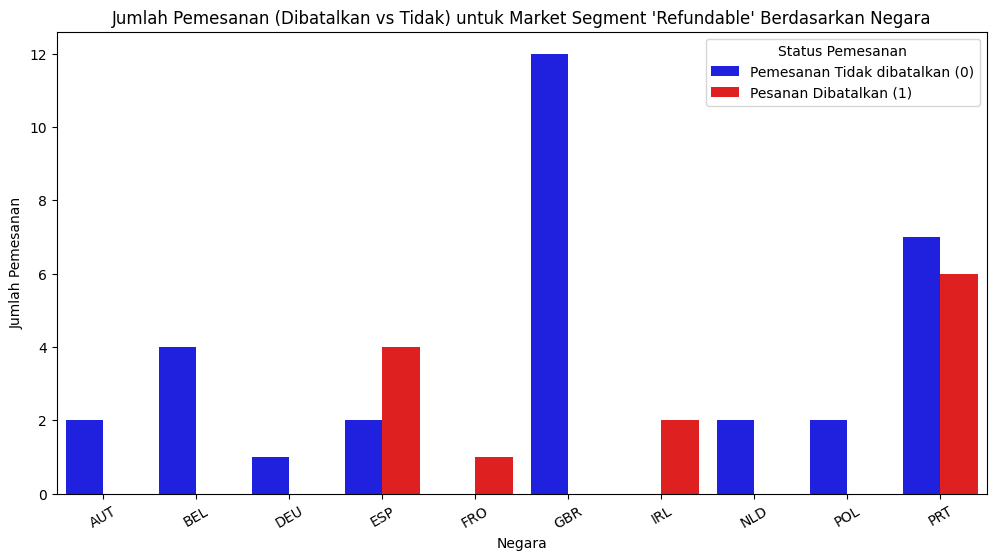

In [99]:
# Loop untuk setiap unique value dalam market_segment
for segment in df["deposit_type"].unique():
    # 1. Filter berdasarkan market_segment
    df_segment = df[df["deposit_type"] == segment]

    # 2. Hitung jumlah pemesanan berdasarkan negara & status pembatalan
    country_cancel = df_segment.groupby(["country", "is_canceled"])[
        "is_canceled"].count().reset_index(name="counts")

    # 3. Ambil 10 negara dengan jumlah pemesanan terbanyak
    top_10_countries = country_cancel.groupby(
        "country")["counts"].sum().nlargest(10).index
    country_cancel = country_cancel[country_cancel["country"].isin(
        top_10_countries)]

    # 4. Pilih warna (Merah untuk Dibatalkan, Biru untuk Berhasil)
    colors = {0: "blue", 1: "red"}  # 0 = Pemesanan Berhasil, 1 = Dibatalkan

    # 5. Buat barplot dengan warna yang sesuai
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=country_cancel, x="country",
                     y="counts", hue="is_canceled", palette=colors)

    # 6. Tambahkan label dan judul
    plt.title(
        f"Jumlah Pemesanan (Dibatalkan vs Tidak) untuk Market Segment '{segment}' Berdasarkan Negara", fontsize=12)
    plt.xlabel("Negara")
    plt.ylabel("Jumlah Pemesanan")

    # 7. Perbaiki legend agar warnanya sama dengan barplot
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Pemesanan Tidak dibatalkan (0)", "Pesanan Dibatalkan (1)"],
               title="Status Pemesanan", loc="upper right")

    # 8. Rotate label sumbu x agar lebih mudah dibaca
    plt.xticks(rotation=30)

    # 9. Tampilkan plot
    plt.show()

Feature engineering yang dilakukan adalah dengan mengubah klasifikasi negara menjadi Portugal dan Non Portugal. Karena kolom country tidak terlalu berpengaruh terhadap target, dan kalau tidak di rubah seperti ini, maka akan terlalu banyak kolom ketika di encoding.

In [100]:
df['country'] = np.where(df['country'].isnull() == True, 'Other', np.where(
    df['country'] == 'PRT', 'Portugal', 'Non Portugal'))

## **Define x and y**


In [101]:
x = df.drop(columns='is_canceled')
y = df['is_canceled']

In [102]:
x

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests
0,Non Portugal,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0
1,Non Portugal,Online TA,0,0,No Deposit,0,Transient,A,0,2
2,Portugal,Online TA,0,1,No Deposit,0,Transient,A,0,2
3,Non Portugal,Online TA,0,0,No Deposit,0,Transient,A,0,1
4,Portugal,Online TA,0,2,No Deposit,0,Transient,A,0,2
...,...,...,...,...,...,...,...,...,...,...
83515,Non Portugal,Direct,0,2,No Deposit,0,Transient-Party,A,1,1
83543,Non Portugal,Online TA,0,0,No Deposit,0,Transient-Party,C,0,2
83554,Non Portugal,Groups,0,0,No Deposit,0,Transient-Party,A,0,1
83562,Non Portugal,Online TA,0,0,No Deposit,0,Transient,B,0,0


## **Train Test Splitting**


In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2, stratify=y)

## **Data Preprocessing**


In [104]:
pd.set_option('display.max_colwidth', 10000)

# data unit di tiap kolom
listItem = []
for col in df.columns:
    listItem.append([col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                          data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,country,2,"[Non Portugal, Portugal]"
1,market_segment,7,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


- Onehot --> Robust: ['country', 'deposit_type', 'customer_type']
- Binary --> Robust: ['market_segment', 'reserved_room_type']
- Robust: ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']

Mengapa reserved_room_type saya masukkan kedalam Binary? Karena isi dari datanya hanya kode huruf yang menunjukkan anonimitas, sehingga saya masih belum tahu apakah kelas 'A' lebih tinggi dibandingkan dengan kelas 'P', kelas 'B' lebih tinggi dibandingkan kelas 'E', dan lain-lain.

In [105]:
pipe_bin_robust = Pipeline([
    ('binary', BinaryEncoder()),
    ('robust', RobustScaler())
])

pipe_onehot_robust = Pipeline([
    ('binary', OneHotEncoder()),
    ('robust', RobustScaler(with_centering=False))
])

In [106]:
transformer = ColumnTransformer([
    ('pipe_bin_robust', pipe_bin_robust, ['market_segment', 'reserved_room_type']),
    ('pipe_onehot_robust', pipe_onehot_robust, ['country', 'deposit_type', 'customer_type']),
    ('robust', RobustScaler(), ['previous_cancellations', 'booking_changes','days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'])
], remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_bin_robust',
                                 Pipeline(steps=[('binary', BinaryEncoder()),
                                                 ('robust', RobustScaler())]),
                                 ['market_segment', 'reserved_room_type']),
                                ('pipe_onehot_robust',
                                 Pipeline(steps=[('binary', OneHotEncoder()),
                                                 ('robust',
                                                  RobustScaler(with_centering=False))]),
                                 ['country', 'deposit_type', 'customer_type']),
                                ('robust', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

Mari kita cek semua model. Kira-kira model mana yang memiliki skor terbaik


In [ ]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(random_state=0, max_depth=5)
rf = RandomForestClassifier(random_state=0)
xgboost = XGBClassifier()
lgbm = lgb.LGBMClassifier(random_state=0)
votinghard = VotingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], voting='hard')
votingsoft = VotingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], voting='soft')
stacking_tree = StackingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], final_estimator=tree)
stacking_logreg = StackingClassifier(estimators=[('logreg', logreg), ('knn', knn), ('tree', tree)], final_estimator=logreg)
bagging_tree = BaggingClassifier(estimator=tree, random_state=0)
bagging_logreg = BaggingClassifier(estimator=logreg, random_state=0)
ada_tree = AdaBoostClassifier(random_state=0, estimator=tree)
ada_logreg = AdaBoostClassifier(random_state=0, estimator=logreg)
gbm = GradientBoostingClassifier(random_state=0)

In [108]:
beta_fhalf = 0.744

In [109]:
scoring_f2 = make_scorer(fbeta_score, beta=2)
fhalf_scorer = make_scorer(fbeta_score, beta=beta_fhalf)

In [110]:
list_model = [logreg, knn, tree, votinghard, votingsoft ,stacking_tree, stacking_logreg, bagging_tree, bagging_logreg, rf, ada_tree, ada_logreg, xgboost, lgbm, gbm]
list_all_score = []
list_mean_score = []
list_std_score = []
for model in list_model:
    skfold = StratifiedKFold(n_splits=5)

    # pipeline
    pipe_prep_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    crossval = cross_val_score(estimator=pipe_prep_model, X=x_train, y=y_train, cv=skfold, scoring=fhalf_scorer)

    # recall score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std_score.append(crossval.std())

[LightGBM] [Info] Number of positive: 1532, number of negative: 4920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 6452, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237446 -> initscore=-1.166734
[LightGBM] [Info] Start training from score -1.166734
[LightGBM] [Info] Number of positive: 1533, number of negative: 4920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 6453, number of used features: 21
[LightGBM] [Info] [binary:

In [111]:
# DF Score
df_score = pd.DataFrame()
# [logreg, knn, tree, votinghard, votingsoft ,stacking, bagging, rf, boost, xgboost, lgbm, gbm]
df_score['model'] = ['LogReg', 'KNN', 'DecTree', 'VotingHard', 'VotingSoft', 'StackingTree', 'StackingLogreg', 'BaggingTree', 'BaggingLogreg', 'RandomForest', 'AdaTree', 'AdaLogreg', 'XGBoost', 'LGBM', 'GradientBoosting']
df_score['all_score'] = list_all_score
df_score['mean_score'] = list_mean_score
df_score['std_score'] = list_std_score
df_score.sort_values(by='mean_score', ascending=False)

,model,all_score,mean_score,std_score
10,AdaTree,"[0.48, 0.5, 0.46, 0.44, 0.47]",0.469255,0.022842
13,LGBM,"[0.45, 0.49, 0.44, 0.46, 0.48]",0.463414,0.018714
14,GradientBoosting,"[0.47, 0.48, 0.44, 0.46, 0.45]",0.460328,0.015356
11,AdaLogreg,"[0.48, 0.38, 0.45, 0.49, 0.46]",0.449345,0.036963
9,RandomForest,"[0.45, 0.46, 0.42, 0.43, 0.47]",0.448473,0.018333
6,StackingLogreg,"[0.44, 0.42, 0.41, 0.4, 0.49]",0.431498,0.029721
0,LogReg,"[0.41, 0.43, 0.44, 0.42, 0.43]",0.424485,0.009607
1,KNN,"[0.37, 0.42, 0.43, 0.42, 0.44]",0.418453,0.026232
8,BaggingLogreg,"[0.41, 0.43, 0.4, 0.38, 0.42]",0.408009,0.016720
5,StackingTree,"[0.45, 0.35, 0.47, 0.48, 0.25]",0.401581,0.087478


Saya akan mengambil 2 model terbaik, yaitu LGBM dan AdaBoosting dengan estimator DecisionTree

## **LGBM**
### **No Treatment**

In [112]:
# Modeling
model_no_treatment_lgbm = Pipeline([
    ('preprocessing', transformer),
    ('modeling', lgbm)
])

# Fitting
model_no_treatment_lgbm.fit(x_train, y_train)

# Predict
y_pred_test_no_treatment_lgbm = model_no_treatment_lgbm.predict(x_test)
y_pred_train_no_treatment_lgbm = model_no_treatment_lgbm.predict(x_train)

# score
accuracy_no_treatment_test_lgbm = accuracy_score(
    y_test, y_pred_test_no_treatment_lgbm)
accuracy_no_treatment_train_lgbm = accuracy_score(
    y_train, y_pred_train_no_treatment_lgbm)

# score
recall_no_treatment_test_lgbm = recall_score(
    y_test, y_pred_test_no_treatment_lgbm)
recall_no_treatment_train_lgbm = recall_score(
    y_train, y_pred_train_no_treatment_lgbm)

# score
precision_no_treatment_test_lgbm = precision_score(
    y_test, y_pred_test_no_treatment_lgbm)
precision_no_treatment_train_lgbm = precision_score(
    y_train, y_pred_train_no_treatment_lgbm)
# score
roc_auc_no_treatment_test_lgbm = roc_auc_score(
    y_test, y_pred_test_no_treatment_lgbm)
roc_auc_no_treatment_train_lgbm = roc_auc_score(
    y_train, y_pred_train_no_treatment_lgbm)
# score
f1_no_treatment_test_lgbm = f1_score(y_test, y_pred_test_no_treatment_lgbm)
f1_no_treatment_train_lgbm = f1_score(y_train, y_pred_train_no_treatment_lgbm)
# score
f03_no_treatment_test_lgbm = fbeta_score(
    y_test, y_pred_test_no_treatment_lgbm, beta=beta_fhalf)
f03_no_treatment_train_lgbm = fbeta_score(
    y_train, y_pred_train_no_treatment_lgbm, beta=beta_fhalf)

print(f"""
Accuracy: 
- Train Score: {accuracy_no_treatment_train_lgbm}
- Test Score: {accuracy_no_treatment_test_lgbm}

Recall: 
- Train Score: {recall_no_treatment_train_lgbm}
- Test Score: {recall_no_treatment_test_lgbm}

Precision: 
- Train Score: {precision_no_treatment_train_lgbm}
- Test Score: {precision_no_treatment_test_lgbm}

ROC-AUC: 
- Train Score: {roc_auc_no_treatment_train_lgbm}
- Test Score: {roc_auc_no_treatment_test_lgbm}

F1: 
- Train Score: {f1_no_treatment_train_lgbm}
- Test Score: {f1_no_treatment_test_lgbm}

F0.76: 
- Train Score: {f03_no_treatment_train_lgbm}
- Test Score: {f03_no_treatment_test_lgbm}
""")

[LightGBM] [Info] Number of positive: 1916, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8066, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237540 -> initscore=-1.166212
[LightGBM] [Info] Start training from score -1.166212

Accuracy: 
- Train Score: 0.8106868336226134
- Test Score: 0.7937530986613783

Recall: 
- Train Score: 0.3721294363256785
- Test Score: 0.33402922755741127

Precision: 
- Train Score: 0.6875602700096431
- Test Score: 0.622568093385214

ROC-AUC: 
- Train Score: 0.659723254748205
- Test Score: 0.6354801534406043

F1: 
- Train Score: 0.4828987470369116
- Test Score: 0.43478260869565216

F0.76: 
- Train Score: 0.5280722647217546
- Test Score: 0.

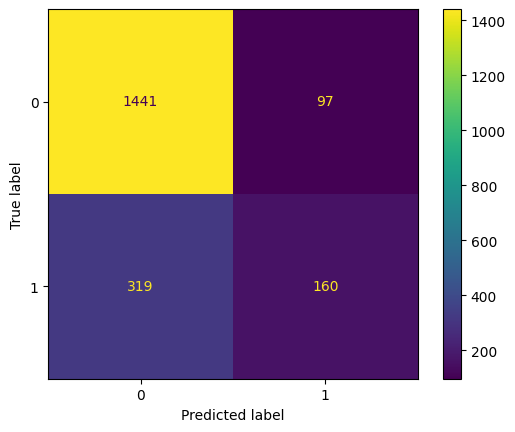

In [113]:
ConfusionMatrixDisplay(confusion_matrix(
    y_test, y_pred_test_no_treatment_lgbm)).plot()

plt.show()

In [114]:
print(classification_report(y_test, y_pred_test_no_treatment_lgbm))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1538
           1       0.62      0.33      0.43       479

    accuracy                           0.79      2017
   macro avg       0.72      0.64      0.65      2017
weighted avg       0.77      0.79      0.77      2017



### **Optimize Threshold**

In [115]:
# Modeling
model_opt_threshold_lgbm = Pipeline([
    ('preprocessing', transformer),
    ('modeling', lgbm)
])

# Fitting
model_opt_threshold_lgbm.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1916, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8066, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237540 -> initscore=-1.166212
[LightGBM] [Info] Start training from score -1.166212


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_bin_robust',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['market_segment',
                                                   'reserved_room_type']),
                                                 ('pipe_onehot_robust',
                                                  Pipeline(steps=[('binary',
                                                                   OneHotEncoder()),
                                                                  ('robust',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['country', 'deposit_type',
                                                   'customer_type']),
                                                 ('robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests'])])),
                ('modeling', LGBMClassifier(random_state=0))])

In [116]:
list_threshold_opt_lgbm = np.arange(0, 1, 0.01)
list_accuracy_train_opt_score_lgbm = []
list_accuracy_test_opt_score_lgbm = []
list_recall_train_opt_score_lgbm = []
list_recall_test_opt_score_lgbm = []
list_precision_train_opt_score_lgbm = []
list_precision_test_opt_score_lgbm = []
list_roc_auc_train_opt_score_lgbm = []
list_roc_auc_test_opt_score_lgbm = []
list_f1_train_opt_score_lgbm = []
list_f1_test_opt_score_lgbm = []
list_fhalf_train_opt_score_lgbm = []
list_fhalf_test_opt_score_lgbm = []

for i in list_threshold_opt_lgbm:
    # Predict probability
    y_pred_test_opt_proba_lgbm = model_opt_threshold_lgbm.predict_proba(x_test)[:, 1]
    y_pred_test_opt_lgbm = np.where(y_pred_test_opt_proba_lgbm > i, 1, 0)

    y_pred_train_opt_proba_lgbm = model_opt_threshold_lgbm.predict_proba(x_train)[:, 1]
    y_pred_train_opt_lgbm = np.where(y_pred_train_opt_proba_lgbm > i, 1, 0)

    # score
    list_accuracy_test_opt_score_lgbm.append(
        accuracy_score(y_test, y_pred_test_opt_lgbm))
    list_accuracy_train_opt_score_lgbm.append(
        accuracy_score(y_train, y_pred_train_opt_lgbm))

    # score
    list_recall_test_opt_score_lgbm.append(
        recall_score(y_test, y_pred_test_opt_lgbm))
    list_recall_train_opt_score_lgbm.append(
        recall_score(y_train, y_pred_train_opt_lgbm))
    
    # score
    list_precision_test_opt_score_lgbm.append(
        precision_score(y_test, y_pred_test_opt_lgbm))
    list_precision_train_opt_score_lgbm.append(
        precision_score(y_train, y_pred_train_opt_lgbm))

    # score
    list_roc_auc_test_opt_score_lgbm.append(roc_auc_score(y_test, y_pred_test_opt_proba_lgbm))
    list_roc_auc_train_opt_score_lgbm.append(roc_auc_score(y_train, y_pred_train_opt_proba_lgbm))

    # score
    list_f1_test_opt_score_lgbm.append(f1_score(y_test, y_pred_test_opt_lgbm))
    list_f1_train_opt_score_lgbm.append(f1_score(y_train, y_pred_train_opt_lgbm))

    # score
    list_fhalf_test_opt_score_lgbm.append(
        fbeta_score(y_test, y_pred_test_opt_lgbm, beta=beta_fhalf))
    list_fhalf_train_opt_score_lgbm.append(fbeta_score(
        y_train, y_pred_train_opt_lgbm, beta=beta_fhalf))

In [117]:
df_threshold_lgbm = pd.DataFrame()
df_threshold_lgbm['threshold'] = list_threshold_opt_lgbm
df_threshold_lgbm['accuracy_train_score'] = list_accuracy_train_opt_score_lgbm
df_threshold_lgbm['accuracy_test_score'] = list_accuracy_test_opt_score_lgbm
df_threshold_lgbm['recall_train_score'] = list_recall_train_opt_score_lgbm
df_threshold_lgbm['recall_test_score'] = list_recall_test_opt_score_lgbm
df_threshold_lgbm['precision_train_score'] = list_precision_train_opt_score_lgbm
df_threshold_lgbm['precision_test_score'] = list_precision_test_opt_score_lgbm
df_threshold_lgbm['roc_auc_train_score'] = list_roc_auc_train_opt_score_lgbm
df_threshold_lgbm['roc_auc_test_score'] = list_roc_auc_test_opt_score_lgbm
df_threshold_lgbm['f1_train_score'] = list_f1_train_opt_score_lgbm
df_threshold_lgbm['f1_test_score'] = list_f1_test_opt_score_lgbm
df_threshold_lgbm['fhalf_train_score'] = list_fhalf_train_opt_score_lgbm
df_threshold_lgbm['fhalf_test_score'] = list_fhalf_test_opt_score_lgbm

# pd.set_option('display.max_rows', None)
df_threshold_lgbm.sort_values(by='accuracy_test_score', ascending=False)

,threshold,accuracy_train_score,accuracy_test_score,recall_train_score,recall_test_score,precision_train_score,precision_test_score,roc_auc_train_score,roc_auc_test_score,f1_train_score,f1_test_score,fhalf_train_score,fhalf_test_score
56,0.56,0.806100,0.797224,0.254175,0.235908,0.782958,0.724359,0.875322,0.834618,0.383767,0.355906,0.449651,0.416840
54,0.54,0.808827,0.796232,0.317328,0.286013,0.722090,0.665049,0.875322,0.834618,0.440899,0.400000,0.496459,0.451740
53,0.53,0.808951,0.795736,0.324635,0.288100,0.715765,0.660287,0.875322,0.834618,0.446679,0.401163,0.500784,0.452158
52,0.52,0.809571,0.795736,0.350209,0.313152,0.697505,0.643777,0.875322,0.834618,0.466296,0.421348,0.515394,0.467798
55,0.55,0.806596,0.795736,0.258873,0.237996,0.779874,0.708075,0.875322,0.834618,0.388715,0.356250,0.454182,0.415595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.04,0.588520,0.578582,0.998434,0.985386,0.365844,0.358935,0.875322,0.834618,0.535479,0.526198,0.472514,0.464052
3,0.03,0.577114,0.566683,0.998956,0.987474,0.359572,0.352722,0.875322,0.834618,0.528802,0.519780,0.465800,0.457507
2,0.02,0.555914,0.549826,0.998956,0.991649,0.348380,0.344453,0.875322,0.834618,0.516599,0.511302,0.453648,0.448823
1,0.01,0.528763,0.522062,1.000000,0.993737,0.335141,0.331246,0.875322,0.834618,0.502031,0.496868,0.439180,0.434442


Threshold Terbaik: 0.62. Kita akan pakai

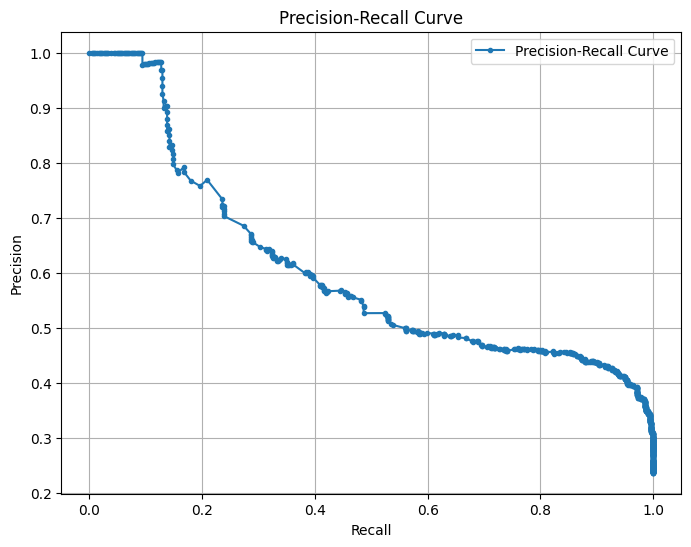

In [118]:
# Hitung precision dan recall
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_test_opt_proba_lgbm)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
# Modeling
model_opt_threshold_lgbm_final = Pipeline([
    ('preprocessing', transformer),
    ('modeling', lgbm)
])

# Fitting
model_opt_threshold_lgbm_final.fit(x_train, y_train)

y_pred_test_opt_proba_lgbm_final = model_opt_threshold_lgbm_final.predict_proba(x_test)[
    :, 1]
y_pred_test_opt_lgbm_final = np.where(y_pred_test_opt_proba_lgbm_final > 0.79, 1, 0)

y_pred_train_opt_proba_lgbm_final = model_opt_threshold_lgbm_final.predict_proba(x_train)[
    :, 1]
y_pred_train_opt_lgbm_final = np.where(y_pred_train_opt_proba_lgbm_final > 0.79, 1, 0)

# score
print(f"""
Accuracy: 
- Train Score: {accuracy_score(y_train, y_pred_train_opt_lgbm_final)}
- Test Score: {accuracy_score(y_test, y_pred_test_opt_lgbm_final)}

Recall: 
- Train Score: {recall_score(y_train, y_pred_train_opt_lgbm_final)}
- Test Score: {recall_score(y_test, y_pred_test_opt_lgbm_final)}

Precision: 
- Train Score: {precision_score(y_train, y_pred_train_opt_lgbm_final)}
- Test Score: {precision_score(y_test, y_pred_test_opt_lgbm_final)}

ROC-AUC: 
- Train Score: {roc_auc_score(y_train, y_pred_train_opt_proba_lgbm_final)}
- Test Score: {roc_auc_score(y_test, y_pred_test_opt_proba_lgbm_final)}

F1: 
- Train Score: {f1_score(y_train, y_pred_train_opt_lgbm_final)}
- Test Score: {f1_score(y_test, y_pred_test_opt_lgbm_final)}

F0.22: 
- Train Score: {fbeta_score(y_train, y_pred_train_opt_lgbm_final, beta=beta_fhalf)}
- Test Score: {fbeta_score(y_test, y_pred_test_opt_lgbm_final, beta=beta_fhalf)}
      """)

[LightGBM] [Info] Number of positive: 1916, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8066, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237540 -> initscore=-1.166212
[LightGBM] [Info] Start training from score -1.166212

Accuracy: 
- Train Score: 0.7933300272749814
- Test Score: 0.7922657411998016

Recall: 
- Train Score: 0.1315240083507307
- Test Score: 0.12943632567849686

Precision: 
- Train Score: 0.9882352941176471
- Test Score: 0.96875

ROC-AUC: 
- Train Score: 0.8753224875672556
- Test Score: 0.834618339572853

F1: 
- Train Score: 0.23215108245048366
- Test Score: 0.2283609576427256

F0.22: 
- Train Score: 0.29758172596922366
- Test Score: 0.292635767

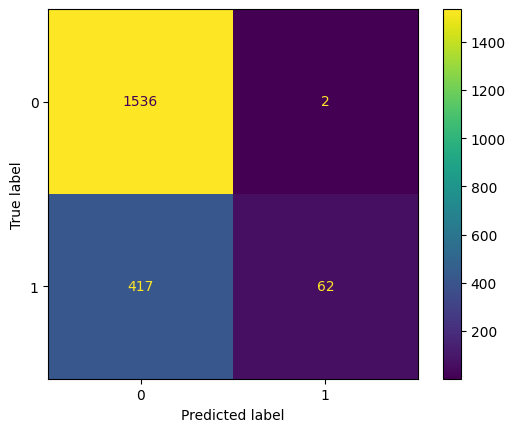

In [120]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_opt_lgbm_final)).plot()

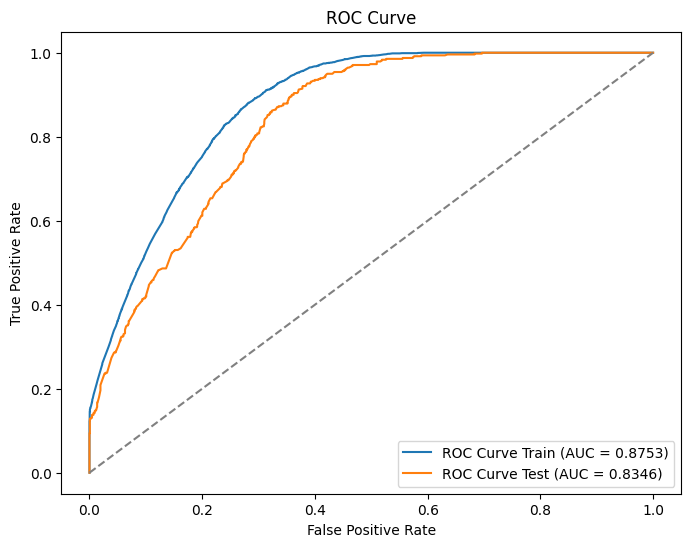

In [121]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test_opt_proba_lgbm_final)
fpr2, tpr2, _ = roc_curve(y_train, y_pred_train_opt_proba_lgbm_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2,
         label=f'ROC Curve Train (AUC = {roc_auc_score(y_train, y_pred_train_opt_proba_lgbm_final):.4f})')
plt.plot(
    fpr, tpr, label=f'ROC Curve Test (AUC = {roc_auc_score(y_test, y_pred_test_opt_proba_lgbm_final):.4f})')
# Garis diagonal sebagai baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [122]:
print(classification_report(y_test, y_pred_test_opt_lgbm_final))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1538
           1       0.97      0.13      0.23       479

    accuracy                           0.79      2017
   macro avg       0.88      0.56      0.55      2017
weighted avg       0.83      0.79      0.73      2017



### **Resampling**


In [123]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nm = NearMiss(sampling_strategy='majority')
smote = SMOTE(sampling_strategy='minority', random_state=0)

x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
# x_train_nm, y_train_nm = nm.fit_resample(x_train, y_train)
# x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## **Hyperparameter Tuning**

In [124]:
x_train.shape

(8066, 10)

In [125]:
x_test.shape

(2017, 10)

In [126]:
# Modeling
model_opt_threshold_lgbm_tuning = imbpl([
    ('preprocessing', transformer),
    ('resampler', None),
    ('modeling', lgbm)
])

# skfold = StratifiedKFold(n_splits=5)
# Hyperparam
hyperparam = {
    'resampler': [None, ros, rus, nm, smote],
    'modeling__n_estimators': [100, 300, 500, 1000],
    'modeling__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'modeling__max_depth': [-1, 3, 5, 7, 10],
    'modeling__num_leaves': [20, 31, 40, 50, 60],
    'modeling__min_child_samples': [10, 20, 30, 50, 100],
    'modeling__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'modeling__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'modeling__reg_alpha': [0, 0.1, 0.5, 1, 2],
    'modeling__reg_lambda': [0, 0.1, 0.5, 1, 2],
    'modeling__scale_pos_weight': [1, 2, 5, 10, 20]  # Untuk menangani imbalance
}

# Randomized Search CV
randomized_lgbm = RandomizedSearchCV(
    estimator=model_opt_threshold_lgbm_tuning,
    param_distributions=hyperparam,
    scoring=fhalf_scorer,
    n_iter=200,
    cv=5,
    n_jobs=-1,
    random_state=0
)

randomized_lgbm.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1916, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 8066, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237540 -> initscore=-1.166212
[LightGBM] [Info] Start training from score -1.166212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_bin_robust',
                                                                               Pipeline(steps=[('binary',
                                                                                                BinaryEncoder()),
                                                                                               ('robust',
                                                                                                RobustScaler())]),
                                                                               ['market_segment',
                                                                                'reserved_room_type']),
                                                                              ('pipe_onehot_robust',
                                                                               Pipeline(steps=[('binary',
                                                                                                OneHotEncoder()),
                                                                                               ('robust',
                                                                                                RobustScaler(with_cen...
                                        'modeling__scale_pos_weight': [1, 2, 5,
                                                                       10, 20],
                                        'modeling__subsample': [0.6, 0.7, 0.8,
                                                                0.9, 1.0],
                                        'resampler': [None,
                                                      RandomOverSampler(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      NearMiss(sampling_strategy='majority'),
                                                      SMOTE(random_state=0,
                                                            sampling_strategy='minority')]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=0.744))

In [127]:
randomized_lgbm.best_score_

np.float64(0.5533554052990197)

In [128]:
randomized_lgbm.best_params_

{'resampler': None,
 'modeling__subsample': 0.8,
 'modeling__scale_pos_weight': 2,
 'modeling__reg_lambda': 0,
 'modeling__reg_alpha': 0,
 'modeling__num_leaves': 31,
 'modeling__n_estimators': 1000,
 'modeling__min_child_samples': 100,
 'modeling__max_depth': 10,
 'modeling__learning_rate': 0.01,
 'modeling__colsample_bytree': 0.8}

In [129]:
pd.DataFrame(randomized_lgbm.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_modeling__subsample,param_modeling__scale_pos_weight,param_modeling__reg_lambda,param_modeling__reg_alpha,param_modeling__num_leaves,...,param_modeling__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
88,9.196224,0.200967,0.134356,0.023274,None,0.8,2,0.0,0.0,31,...,0.8,"{'resampler': None, 'modeling__subsample': 0.8, 'modeling__scale_pos_weight': 2, 'modeling__reg_lambda': 0, 'modeling__reg_alpha': 0, 'modeling__num_leaves': 31, 'modeling__n_estimators': 1000, 'modeling__min_child_samples': 100, 'modeling__max_depth': 10, 'modeling__learning_rate': 0.01, 'modeling__colsample_bytree': 0.8}",0.560543,0.551572,0.558141,0.544556,0.551964,0.553355,0.005606,1
132,2.489893,0.116004,0.047378,0.003323,"SMOTE(random_state=0, sampling_strategy='minority')",0.7,1,0.1,0.0,60,...,0.7,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__subsample': 0.7, 'modeling__scale_pos_weight': 1, 'modeling__reg_lambda': 0.1, 'modeling__reg_alpha': 0, 'modeling__num_leaves': 60, 'modeling__n_estimators': 500, 'modeling__min_child_samples': 30, 'modeling__max_depth': 3, 'modeling__learning_rate': 0.05, 'modeling__colsample_bytree': 0.7}",0.552455,0.554419,0.548304,0.560129,0.548950,0.552851,0.004277,2
126,4.595221,0.338847,0.069755,0.015411,None,0.9,2,2.0,2.0,40,...,0.9,"{'resampler': None, 'modeling__subsample': 0.9, 'modeling__scale_pos_weight': 2, 'modeling__reg_lambda': 2, 'modeling__reg_alpha': 2, 'modeling__num_leaves': 40, 'modeling__n_estimators': 500, 'modeling__min_child_samples': 100, 'modeling__max_depth': 7, 'modeling__learning_rate': 0.01, 'modeling__colsample_bytree': 0.9}",0.554724,0.531470,0.557466,0.561492,0.557624,0.552555,0.010761,3
53,6.316471,0.648152,0.112024,0.015461,None,0.9,2,2.0,0.5,20,...,0.6,"{'resampler': None, 'modeling__subsample': 0.9, 'modeling__scale_pos_weight': 2, 'modeling__reg_lambda': 2, 'modeling__reg_alpha': 0.5, 'modeling__num_leaves': 20, 'modeling__n_estimators': 1000, 'modeling__min_child_samples': 30, 'modeling__max_depth': 10, 'modeling__learning_rate': 0.05, 'modeling__colsample_bytree': 0.6}",0.555839,0.564560,0.554396,0.527653,0.548534,0.550196,0.012384,4
71,5.230505,0.332932,0.077869,0.004736,None,0.8,2,2.0,1.0,40,...,0.7,"{'resampler': None, 'modeling__subsample': 0.8, 'modeling__scale_pos_weight': 2, 'modeling__reg_lambda': 2, 'modeling__reg_alpha': 1, 'modeling__num_leaves': 40, 'modeling__n_estimators': 1000, 'modeling__min_child_samples': 20, 'modeling__max_depth': 5, 'modeling__learning_rate': 0.05, 'modeling__colsample_bytree': 0.7}",0.557491,0.554831,0.561914,0.535283,0.539687,0.549841,0.010433,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.392833,0.167451,0.036039,0.002429,None,0.7,5,0.1,0.0,20,...,0.8,"{'resampler': None, 'modeling__subsample': 0.7, 'modeling__scale_pos_weight': 5, 'modeling__reg_lambda': 0.1, 'modeling__reg_alpha': 0, 'modeling__num_leaves': 20, 'modeling__n_estimators': 100, 'modeling__min_child_samples': 20, 'modeling__max_depth': 3, 'modeling__learning_rate': 0.001, 'modeling__colsample_bytree': 0.8}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,196
12,0.471741,0.088314,0.052324,0.010896,None,1.0,10,2.0,0.1,20,...,0.9,"{'resampler': None, 'modeling__subsample': 1.0, 'modeling__scale_pos_weight': 10, 'modeling__reg_lambda': 2, 'modeling__reg_alpha': 0.1, 'modeling__num_leaves': 20, 'modeling__n_estimators': 100, 'modeling__min_child_samples': 20, 'modeling__max_depth': 3, 'modeling__learning_rate': 0.001, 'modeling__colsample_bytree': 0.9}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,196
74,0.799837,0.085775,0.040832,0.003663,None,1.0,10,2.0,0.1,60,...,0.6,"{'resampler': None, 'modeling__subsample': 1.0, 'modeling__scale_pos_weight': 10, 'modeling__reg_lambda': 2, 'modeling_

## **Remodeling With Best Params**

In [130]:
randomized_lgbm.best_params_

{'resampler': None,
 'modeling__subsample': 0.8,
 'modeling__scale_pos_weight': 2,
 'modeling__reg_lambda': 0,
 'modeling__reg_alpha': 0,
 'modeling__num_leaves': 31,
 'modeling__n_estimators': 1000,
 'modeling__min_child_samples': 100,
 'modeling__max_depth': 10,
 'modeling__learning_rate': 0.01,
 'modeling__colsample_bytree': 0.8}

[LightGBM] [Info] Number of positive: 1916, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 8066, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237540 -> initscore=-1.166212
[LightGBM] [Info] Start training from score -1.166212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

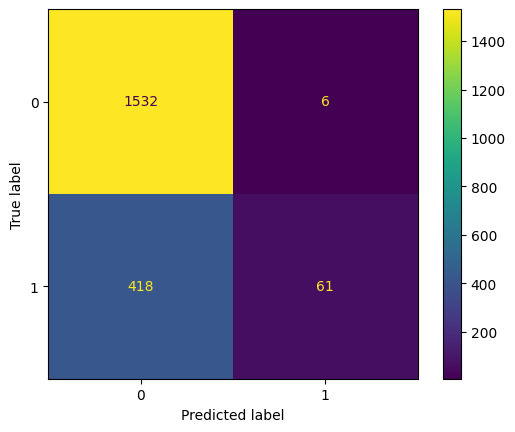

In [216]:
# model_lgbm
model_lgbm = randomized_lgbm.best_estimator_

# fitting
model_lgbm.fit(x_train, y_train)

y_pred_test_proba_lgbm = model_lgbm.predict_proba(x_test)[:, 1]
y_pred_test_lgbm = np.where(y_pred_test_proba_lgbm > 0.82, 1, 0)

y_pred_train_proba_lgbm = model_lgbm.predict_proba(x_train)[:, 1]
y_pred_train_lgbm = np.where(y_pred_train_proba_lgbm > 0.82, 1, 0)

# score
fbeta_model_test_lgbm = fbeta_score(y_test, y_pred_test_lgbm, beta=beta_fhalf)
fbeta_model_train_lgbm = fbeta_score(y_train, y_pred_train_lgbm, beta=beta_fhalf)

# score
roc_auc_model_test_lgbm = roc_auc_score(y_test, y_pred_test_lgbm)
roc_auc_model_train_lgbm = roc_auc_score(y_train, y_pred_train_lgbm)
print(f"""
F0.76: 
Train Score: {fbeta_model_train_lgbm}
Test Score: {fbeta_model_test_lgbm}

ROC-AUC
Train Score: {roc_auc_model_train_lgbm}
Test Score: {roc_auc_model_test_lgbm}
""")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_lgbm)).plot()
plt.show()

## **AdaBoosting**
### **No Treatment**

In [132]:
# Modeling
model_no_treatment_ada_tree = Pipeline([
    ('preprocessing', transformer),
    ('modeling', ada_tree)
])

# Fitting
model_no_treatment_ada_tree.fit(x_train, y_train)

# Predict
y_pred_test_no_treatment_ada_tree = model_no_treatment_ada_tree.predict(x_test)
y_pred_train_no_treatment_ada_tree = model_no_treatment_ada_tree.predict(x_train)

# score
accuracy_no_treatment_test_ada_tree = accuracy_score(
    y_test, y_pred_test_no_treatment_ada_tree)
accuracy_no_treatment_train_ada_tree = accuracy_score(
    y_train, y_pred_train_no_treatment_ada_tree)

# score
recall_no_treatment_test_ada_tree = recall_score(
    y_test, y_pred_test_no_treatment_ada_tree)
recall_no_treatment_train_ada_tree = recall_score(
    y_train, y_pred_train_no_treatment_ada_tree)

# score
precision_no_treatment_test_ada_tree = precision_score(
    y_test, y_pred_test_no_treatment_ada_tree)
precision_no_treatment_train_ada_tree = precision_score(
    y_train, y_pred_train_no_treatment_ada_tree)
# score
roc_auc_no_treatment_test_ada_tree = roc_auc_score(
    y_test, y_pred_test_no_treatment_ada_tree)
roc_auc_no_treatment_train_ada_tree = roc_auc_score(
    y_train, y_pred_train_no_treatment_ada_tree)
# score
f1_no_treatment_test_ada_tree = f1_score(y_test, y_pred_test_no_treatment_ada_tree)
f1_no_treatment_train_ada_tree = f1_score(y_train, y_pred_train_no_treatment_ada_tree)
# score
f03_no_treatment_test_ada_tree = fbeta_score(
    y_test, y_pred_test_no_treatment_ada_tree, beta=beta_fhalf)
f03_no_treatment_train_ada_tree = fbeta_score(
    y_train, y_pred_train_no_treatment_ada_tree, beta=beta_fhalf)

print(f"""
Accuracy: 
- Train Score: {accuracy_no_treatment_train_ada_tree}
- Test Score: {accuracy_no_treatment_test_ada_tree}

Recall: 
- Train Score: {recall_no_treatment_train_ada_tree}
- Test Score: {recall_no_treatment_test_ada_tree}

Precision: 
- Train Score: {precision_no_treatment_train_ada_tree}
- Test Score: {precision_no_treatment_test_ada_tree}

ROC-AUC: 
- Train Score: {roc_auc_no_treatment_train_ada_tree}
- Test Score: {roc_auc_no_treatment_test_ada_tree}

F1: 
- Train Score: {f1_no_treatment_train_ada_tree}
- Test Score: {f1_no_treatment_test_ada_tree}

F0.76: 
- Train Score: {f03_no_treatment_train_ada_tree}
- Test Score: {f03_no_treatment_test_ada_tree}
""")


Accuracy: 
- Train Score: 0.7971733201090999
- Test Score: 0.7967278135845315

Recall: 
- Train Score: 0.3355949895615866
- Test Score: 0.31524008350730687

Precision: 
- Train Score: 0.6391650099403579
- Test Score: 0.648068669527897

ROC-AUC: 
- Train Score: 0.6382852996588421
- Test Score: 0.6309620443544336

F1: 
- Train Score: 0.4401095140314853
- Test Score: 0.4241573033707865

F0.76: 
- Train Score: 0.4833715977406668
- Test Score: 0.4709161538722445



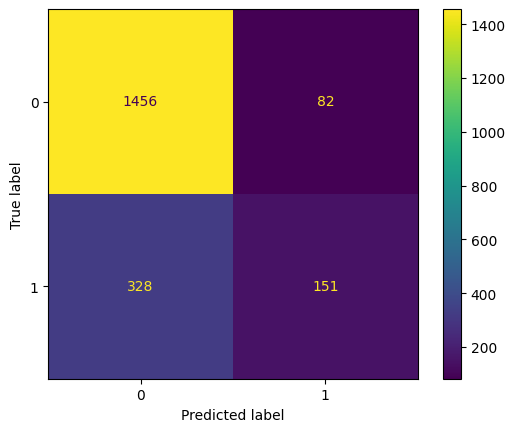

In [133]:
ConfusionMatrixDisplay(confusion_matrix(
    y_test, y_pred_test_no_treatment_ada_tree)).plot()

plt.show()

In [134]:
print(classification_report(y_test, y_pred_test_no_treatment_ada_tree))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1538
           1       0.65      0.32      0.42       479

    accuracy                           0.80      2017
   macro avg       0.73      0.63      0.65      2017
weighted avg       0.78      0.80      0.77      2017



### **Optimize Threshold**


In [135]:
# Modeling
model_opt_threshold_ada_tree = Pipeline([
    ('preprocessing', transformer),
    ('modeling', ada_tree)
])

# Fitting
model_opt_threshold_ada_tree.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_bin_robust',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['market_segment',
                                                   'reserved_room_type']),
                                                 ('pipe_onehot_robust',
                                                  Pipeline(steps=[('binary',
                                                                   OneHotEncoder()),
                                                                  ('robust',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['country', 'deposit_type',
                                                   'customer_type']),
                                                 ('robust', RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests'])])),
                ('modeling',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                                     random_state=0),
                                    random_state=0))])

In [136]:
list_threshold_opt_ada_tree = np.arange(0, 1, 0.01)
list_accuracy_train_opt_score_ada_tree = []
list_accuracy_test_opt_score_ada_tree = []
list_recall_train_opt_score_ada_tree = []
list_recall_test_opt_score_ada_tree = []
list_precision_train_opt_score_ada_tree = []
list_precision_test_opt_score_ada_tree = []
list_roc_auc_train_opt_score_ada_tree = []
list_roc_auc_test_opt_score_ada_tree = []
list_f1_train_opt_score_ada_tree = []
list_f1_test_opt_score_ada_tree = []
list_fhalf_train_opt_score_ada_tree = []
list_fhalf_test_opt_score_ada_tree = []

for i in list_threshold_opt_ada_tree:
    # Predict probability
    y_pred_test_opt_proba_ada_tree = model_opt_threshold_ada_tree.predict_proba(x_test)[:, 1]
    y_pred_test_opt_ada_tree = np.where(y_pred_test_opt_proba_ada_tree > i, 1, 0)

    y_pred_train_opt_proba_ada_tree = model_opt_threshold_ada_tree.predict_proba(x_train)[:, 1]
    y_pred_train_opt_ada_tree = np.where(y_pred_train_opt_proba_ada_tree > i, 1, 0)

    # score
    list_accuracy_test_opt_score_ada_tree.append(
        accuracy_score(y_test, y_pred_test_opt_ada_tree))
    list_accuracy_train_opt_score_ada_tree.append(
        accuracy_score(y_train, y_pred_train_opt_ada_tree))

    # score
    list_recall_test_opt_score_ada_tree.append(
        recall_score(y_test, y_pred_test_opt_ada_tree))
    list_recall_train_opt_score_ada_tree.append(
        recall_score(y_train, y_pred_train_opt_ada_tree))
    
    # score
    list_precision_test_opt_score_ada_tree.append(
        precision_score(y_test, y_pred_test_opt_ada_tree))
    list_precision_train_opt_score_ada_tree.append(
        precision_score(y_train, y_pred_train_opt_ada_tree))

    # score
    list_roc_auc_test_opt_score_ada_tree.append(roc_auc_score(y_test, y_pred_test_opt_proba_ada_tree))
    list_roc_auc_train_opt_score_ada_tree.append(roc_auc_score(y_train, y_pred_train_opt_proba_ada_tree))

    # score
    list_f1_test_opt_score_ada_tree.append(f1_score(y_test, y_pred_test_opt_ada_tree))
    list_f1_train_opt_score_ada_tree.append(f1_score(y_train, y_pred_train_opt_ada_tree))

    # score
    list_fhalf_test_opt_score_ada_tree.append(
        fbeta_score(y_test, y_pred_test_opt_ada_tree, beta=beta_fhalf))
    list_fhalf_train_opt_score_ada_tree.append(fbeta_score(
        y_train, y_pred_train_opt_ada_tree, beta=beta_fhalf))

In [137]:
df_threshold_ada_tree = pd.DataFrame()
df_threshold_ada_tree['threshold'] = list_threshold_opt_ada_tree
df_threshold_ada_tree['accuracy_train_score'] = list_accuracy_train_opt_score_ada_tree
df_threshold_ada_tree['accuracy_test_score'] = list_accuracy_test_opt_score_ada_tree
df_threshold_ada_tree['recall_train_score'] = list_recall_train_opt_score_ada_tree
df_threshold_ada_tree['recall_test_score'] = list_recall_test_opt_score_ada_tree
df_threshold_ada_tree['precision_train_score'] = list_precision_train_opt_score_ada_tree
df_threshold_ada_tree['precision_test_score'] = list_precision_test_opt_score_ada_tree
df_threshold_ada_tree['roc_auc_train_score'] = list_roc_auc_train_opt_score_ada_tree
df_threshold_ada_tree['roc_auc_test_score'] = list_roc_auc_test_opt_score_ada_tree
df_threshold_ada_tree['f1_train_score'] = list_f1_train_opt_score_ada_tree
df_threshold_ada_tree['f1_test_score'] = list_f1_test_opt_score_ada_tree
df_threshold_ada_tree['fhalf_train_score'] = list_fhalf_train_opt_score_ada_tree
df_threshold_ada_tree['fhalf_test_score'] = list_fhalf_test_opt_score_ada_tree

# pd.set_option('display.max_rows', None)
df_threshold_ada_tree.sort_values(by='f1_test_score', ascending=False)

,threshold,accuracy_train_score,accuracy_test_score,recall_train_score,recall_test_score,precision_train_score,precision_test_score,roc_auc_train_score,roc_auc_test_score,f1_train_score,f1_test_score,fhalf_train_score,fhalf_test_score
46,0.46,0.754773,0.757065,0.745303,0.762004,0.489376,0.492578,0.8465,0.842125,0.590815,0.598361,0.557599,0.563578
45,0.45,0.748698,0.748637,0.760960,0.770355,0.481665,0.481723,0.8465,0.842125,0.589925,0.592771,0.554132,0.555941
41,0.41,0.723903,0.713932,0.877871,0.870564,0.457687,0.447425,0.8465,0.842125,0.601681,0.591070,0.551791,0.541142
42,0.42,0.727622,0.720377,0.859603,0.847599,0.460699,0.452620,0.8465,0.842125,0.599891,0.590116,0.551965,0.542735
44,0.44,0.743739,0.740704,0.779749,0.784969,0.475948,0.472362,0.8465,0.842125,0.591098,0.589804,0.552671,0.550472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.95,0.762460,0.762519,0.000000,0.000000,0.000000,0.000000,0.8465,0.842125,0.000000,0.000000,0.000000,0.000000
96,0.96,0.762460,0.762519,0.000000,0.000000,0.000000,0.000000,0.8465,0.842125,0.000000,0.000000,0.000000,0.000000
97,0.97,0.762460,0.762519,0.000000,0.000000,0.000000,0.000000,0.8465,0.842125,0.000000,0.000000,0.000000,0.000000
98,0.98,0.762460,0.762519,0.000000,0.000000,0.000000,0.000000,0.8465,0.842125,0.000000,0.000000,0.000000,0.000000


Threshold Terbaik: 0.62. Kita akan pakai

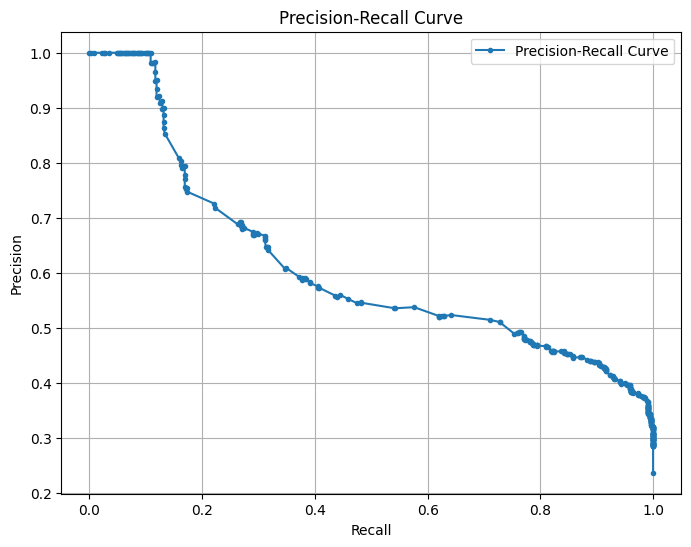

In [138]:
# Hitung precision dan recall
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_test_opt_proba_ada_tree)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [139]:
# Modeling
model_opt_threshold_ada_tree_final = Pipeline([
    ('preprocessing', transformer),
    ('modeling', ada_tree)
])

# Fitting
model_opt_threshold_ada_tree_final.fit(x_train, y_train)

y_pred_test_opt_proba_ada_tree_final = model_opt_threshold_ada_tree_final.predict_proba(x_test)[
    :, 1]
y_pred_test_opt_ada_tree_final = np.where(y_pred_test_opt_proba_ada_tree_final > 0.57, 1, 0)

y_pred_train_opt_proba_ada_tree_final = model_opt_threshold_ada_tree_final.predict_proba(x_train)[
    :, 1]
y_pred_train_opt_ada_tree_final = np.where(y_pred_train_opt_proba_ada_tree_final > 0.57, 1, 0)

# score
print(f"""
Accuracy: 
- Train Score: {accuracy_score(y_train, y_pred_train_opt_ada_tree_final)}
- Test Score: {accuracy_score(y_test, y_pred_test_opt_ada_tree_final)}

Recall: 
- Train Score: {recall_score(y_train, y_pred_train_opt_ada_tree_final)}
- Test Score: {recall_score(y_test, y_pred_test_opt_ada_tree_final)}

Precision: 
- Train Score: {precision_score(y_train, y_pred_train_opt_ada_tree_final)}
- Test Score: {precision_score(y_test, y_pred_test_opt_ada_tree_final)}

ROC-AUC: 
- Train Score: {roc_auc_score(y_train, y_pred_train_opt_proba_ada_tree_final)}
- Test Score: {roc_auc_score(y_test, y_pred_test_opt_proba_ada_tree_final)}

F1: 
- Train Score: {f1_score(y_train, y_pred_train_opt_ada_tree_final)}
- Test Score: {f1_score(y_test, y_pred_test_opt_ada_tree_final)}

F0.22: 
- Train Score: {fbeta_score(y_train, y_pred_train_opt_ada_tree_final, beta=beta_fhalf)}
- Test Score: {fbeta_score(y_test, y_pred_test_opt_ada_tree_final, beta=beta_fhalf)}
      """)


Accuracy: 
- Train Score: 0.7902305975700471
- Test Score: 0.7882994546355975

Recall: 
- Train Score: 0.12526096033402923
- Test Score: 0.11064718162839249

Precision: 
- Train Score: 0.9375
- Test Score: 0.9814814814814815

ROC-AUC: 
- Train Score: 0.8464996096203135
- Test Score: 0.8421254455668641

F1: 
- Train Score: 0.22099447513812154
- Test Score: 0.19887429643527205

F0.22: 
- Train Score: 0.28319590361103747
- Test Score: 0.2579947423315307
      


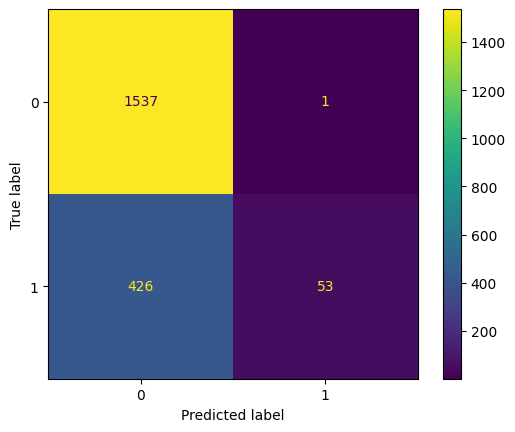

In [140]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_opt_ada_tree_final)).plot()

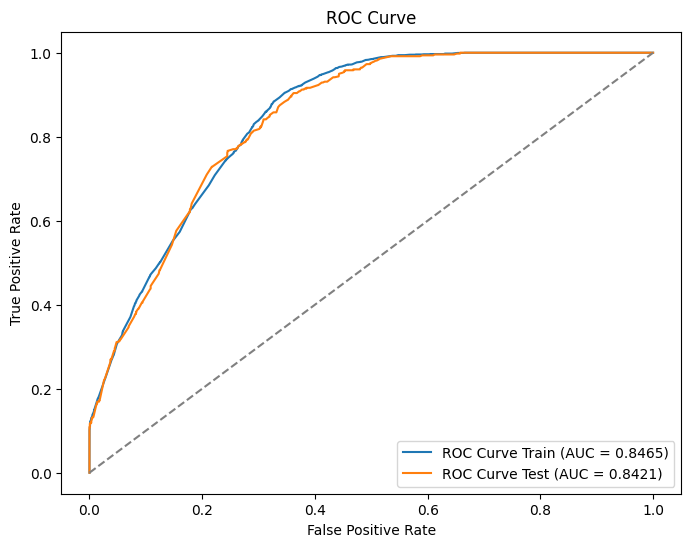

In [141]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test_opt_proba_ada_tree_final)
fpr2, tpr2, _ = roc_curve(y_train, y_pred_train_opt_proba_ada_tree_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2,
         label=f'ROC Curve Train (AUC = {roc_auc_score(y_train, y_pred_train_opt_proba_ada_tree_final):.4f})')
plt.plot(
    fpr, tpr, label=f'ROC Curve Test (AUC = {roc_auc_score(y_test, y_pred_test_opt_proba_ada_tree_final):.4f})')
# Garis diagonal sebagai baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [142]:
print(classification_report(y_test, y_pred_test_opt_ada_tree_final))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1538
           1       0.98      0.11      0.20       479

    accuracy                           0.79      2017
   macro avg       0.88      0.55      0.54      2017
weighted avg       0.83      0.79      0.72      2017



### **Resampling**


In [143]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nm = NearMiss(sampling_strategy='majority')
smote = SMOTE(sampling_strategy='minority', random_state=0)

x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
# x_train_nm, y_train_nm = nm.fit_resample(x_train, y_train)
# x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## **Hyperparameter Tuning**

In [144]:
x_train.shape

(8066, 10)

In [145]:
x_test.shape

(2017, 10)

In [146]:
# Modeling
model_opt_threshold_ada_tree_tuning = imbpl([
    ('preprocessing', transformer),
    ('resampler', None),
    ('modeling', ada_tree)
])
# AdaBoostClassifier()

# skfold = StratifiedKFold(n_splits=5)
# Hyperparam
hyperparam = {
    'modeling__estimator__max_depth': np.arange(3, 30, 2),  # Cegah overfitting
    'modeling__estimator__min_samples_split': np.arange(2, 100, 5),
    'modeling__estimator__min_samples_leaf': np.arange(1, 50, 2),
    'modeling__estimator__max_features': ['sqrt', 'log2', None],
    'modeling__estimator__criterion': ['gini', 'entropy'],
    'modeling__estimator__class_weight': [None, 'balanced'], # Mengatasi imbalanced data

    'resampler': [None, ros, rus, nm, smote],
    'modeling__n_estimators': [50, 100, 200],
    'modeling__algorithm': ['SAMME', 'SAMME.R'],
    'modeling__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'modeling__random_state': [0, 42]
}

# Randomized Search CV
randomized_ada_tree = RandomizedSearchCV(
    estimator=model_opt_threshold_ada_tree_tuning,
    param_distributions=hyperparam,
    scoring=fhalf_scorer,
    n_iter=200,
    cv=5,
    n_jobs=-1,
    random_state=0
)

randomized_ada_tree.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipe_bin_robust',
                                                                               Pipeline(steps=[('binary',
                                                                                                BinaryEncoder()),
                                                                                               ('robust',
                                                                                                RobustScaler())]),
                                                                               ['market_segment',
                                                                                'reserved_room_type']),
                                                                              ('pipe_onehot_robust',
                                                                               Pipeline(steps=[('binary',
                                                                                                OneHotEncoder()),
                                                                                               ('robust',
                                                                                                RobustScaler(with_cen...
                                        'modeling__learning_rate': [0.001, 0.01,
                                                                    0.1, 1, 10,
                                                                    100],
                                        'modeling__n_estimators': [50, 100,
                                                                   200],
                                        'modeling__random_state': [0, 42],
                                        'resampler': [None,
                                                      RandomOverSampler(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      NearMiss(sampling_strategy='majority'),
                                                      SMOTE(random_state=0,
                                                            sampling_strategy='minority')]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=0.744))

In [147]:
randomized_ada_tree.best_score_

np.float64(0.5507098196737998)

In [148]:
randomized_ada_tree.best_params_

{'resampler': SMOTE(random_state=0, sampling_strategy='minority'),
 'modeling__random_state': 42,
 'modeling__n_estimators': 100,
 'modeling__learning_rate': 1,
 'modeling__estimator__min_samples_split': np.int64(37),
 'modeling__estimator__min_samples_leaf': np.int64(47),
 'modeling__estimator__max_features': 'sqrt',
 'modeling__estimator__max_depth': np.int64(3),
 'modeling__estimator__criterion': 'gini',
 'modeling__estimator__class_weight': 'balanced',
 'modeling__algorithm': 'SAMME'}

In [149]:
pd.DataFrame(randomized_ada_tree.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_modeling__random_state,param_modeling__n_estimators,param_modeling__learning_rate,param_modeling__estimator__min_samples_split,param_modeling__estimator__min_samples_leaf,...,param_modeling__algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,1.846562,0.024522,0.120285,0.003840,"SMOTE(random_state=0, sampling_strategy='minority')",42,100,1.00,37,47,...,SAMME,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__random_state': 42, 'modeling__n_estimators': 100, 'modeling__learning_rate': 1, 'modeling__estimator__min_samples_split': 37, 'modeling__estimator__min_samples_leaf': 47, 'modeling__estimator__max_features': 'sqrt', 'modeling__estimator__max_depth': 3, 'modeling__estimator__criterion': 'gini', 'modeling__estimator__class_weight': 'balanced', 'modeling__algorithm': 'SAMME'}",0.544294,0.549597,0.553207,0.561914,0.544536,0.550710,0.006516,1
164,3.019819,0.187413,0.152813,0.012431,"SMOTE(random_state=0, sampling_strategy='minority')",42,100,0.10,17,39,...,SAMME,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__random_state': 42, 'modeling__n_estimators': 100, 'modeling__learning_rate': 0.1, 'modeling__estimator__min_samples_split': 17, 'modeling__estimator__min_samples_leaf': 39, 'modeling__estimator__max_features': 'sqrt', 'modeling__estimator__max_depth': 25, 'modeling__estimator__criterion': 'entropy', 'modeling__estimator__class_weight': 'balanced', 'modeling__algorithm': 'SAMME'}",0.535728,0.563927,0.548977,0.554029,0.543826,0.549297,0.009493,2
0,9.687094,0.104912,0.211704,0.004782,"SMOTE(random_state=0, sampling_strategy='minority')",0,200,0.10,72,25,...,SAMME,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__random_state': 0, 'modeling__n_estimators': 200, 'modeling__learning_rate': 0.1, 'modeling__estimator__min_samples_split': 72, 'modeling__estimator__min_samples_leaf': 25, 'modeling__estimator__max_features': None, 'modeling__estimator__max_depth': 7, 'modeling__estimator__criterion': 'gini', 'modeling__estimator__class_weight': 'balanced', 'modeling__algorithm': 'SAMME'}",0.541874,0.555590,0.547863,0.553661,0.540663,0.547930,0.006017,3
20,1.114966,0.004564,0.090029,0.003881,"SMOTE(random_state=0, sampling_strategy='minority')",0,50,1.00,52,3,...,SAMME,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__random_state': 0, 'modeling__n_estimators': 50, 'modeling__learning_rate': 1, 'modeling__estimator__min_samples_split': 52, 'modeling__estimator__min_samples_leaf': 3, 'modeling__estimator__max_features': 'log2', 'modeling__estimator__max_depth': 3, 'modeling__estimator__criterion': 'entropy', 'modeling__estimator__class_weight': 'balanced', 'modeling__algorithm': 'SAMME'}",0.553840,0.531183,0.551372,0.553287,0.542671,0.546471,0.008637,4
58,5.251915,0.059806,0.240742,0.014904,"SMOTE(random_state=0, sampling_strategy='minority')",42,200,0.01,37,19,...,SAMME,"{'resampler': SMOTE(random_state=0, sampling_strategy='minority'), 'modeling__random_state': 42, 'modeling__n_estimators': 200, 'modeling__learning_rate': 0.01, 'modeling__estimator__min_samples_split': 37, 'modeling__estimator__min_samples_leaf': 19, 'modeling__estimator__max_features': 'sqrt', 'modeling__estimator__max_depth': 15, 'modeling__estimator__criterion': 'entropy', 'modeling__estimator__class_weight': 'balanced', 'modeling__algorithm': 'SAMME'}",0.536843,0.552832,0.551252,0.552714,0.537692,0.546267,0.007374,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.115662,0.003982,0.000000,0.000000,None,0,50,0.10,57,21,...,SAMME.R,"{'resampler': None, 'modeling__random_state': 0, 'modeling__n_estimators': 50, 'modeling__learning_rate': 0.1, 'modeling__estimator__min_samples_split': 57, 'modeling__estimator__min_samples_leaf

## **Remodeling With Best Params**


In [150]:
randomized_ada_tree.best_params_

{'resampler': SMOTE(random_state=0, sampling_strategy='minority'),
 'modeling__random_state': 42,
 'modeling__n_estimators': 100,
 'modeling__learning_rate': 1,
 'modeling__estimator__min_samples_split': np.int64(37),
 'modeling__estimator__min_samples_leaf': np.int64(47),
 'modeling__estimator__max_features': 'sqrt',
 'modeling__estimator__max_depth': np.int64(3),
 'modeling__estimator__criterion': 'gini',
 'modeling__estimator__class_weight': 'balanced',
 'modeling__algorithm': 'SAMME'}


F0.76: 
Train Score: 0.2948489567581824
Test Score: 0.2891221394209942

ROC-AUC: 
Train Score: 0.8452868017719843
Test Score: 0.8386240297976657



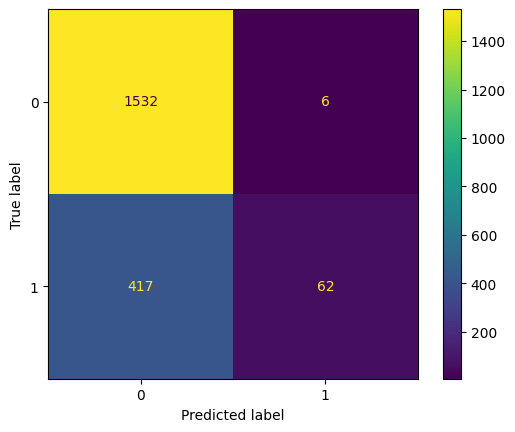

In [215]:
# model_ada_tree
model_ada_tree = randomized_ada_tree.best_estimator_

# fitting
model_ada_tree.fit(x_train, y_train)

y_pred_test_proba_ada_tree = model_ada_tree.predict_proba(x_test)[:, 1]
y_pred_test_ada_tree = np.where(y_pred_test_proba_ada_tree > 0.56, 1, 0)

y_pred_train_proba_ada_tree = model_ada_tree.predict_proba(x_train)[:, 1]
y_pred_train_ada_tree = np.where(y_pred_train_proba_ada_tree > 0.56, 1, 0)

# score
fbeta_model_test_ada_tree = fbeta_score(y_test, y_pred_test_ada_tree, beta=beta_fhalf)
fbeta_model_train_ada_tree = fbeta_score(y_train, y_pred_train_ada_tree, beta=beta_fhalf)

# score
roc_auc_model_test_ada_tree = roc_auc_score(y_test, y_pred_test_proba_ada_tree)
roc_auc_model_train_ada_tree = roc_auc_score(y_train, y_pred_train_proba_ada_tree)
print(f"""
F0.76: 
Train Score: {fbeta_model_train_ada_tree}
Test Score: {fbeta_model_test_ada_tree}

ROC-AUC: 
Train Score: {roc_auc_model_train_ada_tree}
Test Score: {roc_auc_model_test_ada_tree}
""")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_ada_tree)).plot()
plt.show()

## **Evaluation Metrics**

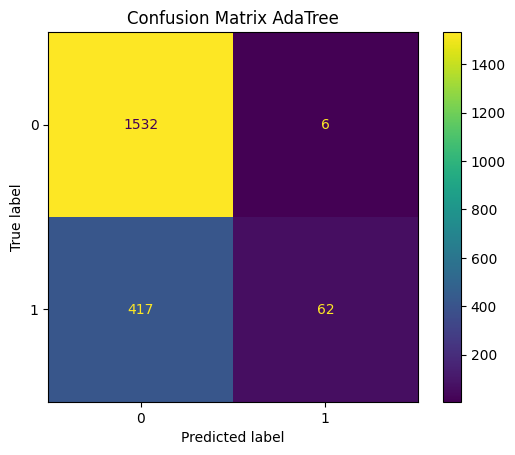

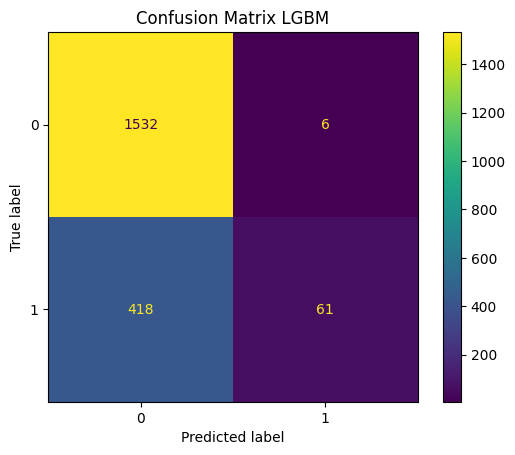

In [217]:
df_best_model = pd.DataFrame()
df_best_model['Model'] = ['AdaBoostClassifier - Tree', 'LGBM']
df_best_model['Fbeta_train_score'] = [fbeta_model_train_ada_tree, fbeta_model_train_lgbm]
df_best_model['Fbeta_test_score'] = [fbeta_model_test_ada_tree, fbeta_model_test_lgbm]
df_best_model['roc_auc_train_score'] = [roc_auc_model_train_ada_tree, roc_auc_model_train_lgbm]
df_best_model['roc_auc_test_score'] = [roc_auc_model_test_ada_tree, roc_auc_model_test_lgbm]

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_ada_tree)).plot()
plt.title('Confusion Matrix AdaTree')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test_lgbm)).plot()
plt.title('Confusion Matrix LGBM')
plt.show()

AdaBoost Tree: 
- FP: 6 * 112 = 672 euro
- FN: 417 * 62 = 25854 euro
- Total: 26526 euro

LGBM: 
- FP: 6 * 112 = 672 euro
- FN: 418 * 62 = 25916 euro
- Total: 26588 euro

Model Ada - Tree sedikit lebih kecil total kerugiannya.

Untuk itu, kita menggunakan model AdaBoosting - Tree.

In [218]:
df_best_model.sort_values(by='roc_auc_test_score', ascending=False)

,Model,Fbeta_train_score,Fbeta_test_score,roc_auc_train_score,roc_auc_test_score
0,AdaBoostClassifier - Tree,0.294849,0.289122,0.845287,0.838624
1,LGBM,0.300065,0.285315,0.566010,0.561724


Kesimpulan: Ada

## **The Best Estimator**

In [175]:
best_model = randomized_ada_tree.best_estimator_
best_model

best_model.fit(x, y)

pickle.dump(best_model, open('model_ada_tree.sav', 'wb'))

In [176]:
model_loaded = pickle.load(open('model_ada_tree.sav', 'rb'))
model_loaded

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_bin_robust',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder()),
                                                                  ('robust',
                                                                   RobustScaler())]),
                                                  ['market_segment',
                                                   'reserved_room_type']),
                                                 ('pipe_onehot_robust',
                                                  Pipeline(steps=[('binary',
                                                                   OneHotEncoder()),
                                                                  ('robust',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['country', 'depos...
                                                   'total_of_special_requests'])])),
                ('resampler',
                 SMOTE(random_state=0, sampling_strategy='minority')),
                ('modeling',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                     max_depth=np.int64(3),
                                                                     max_features='sqrt',
                                                                     min_samples_leaf=np.int64(47),
                                                                     min_samples_split=np.int64(37),
                                                                     random_state=0),
                                    learning_rate=1, n_estimators=100,
                                    random_state=42))])

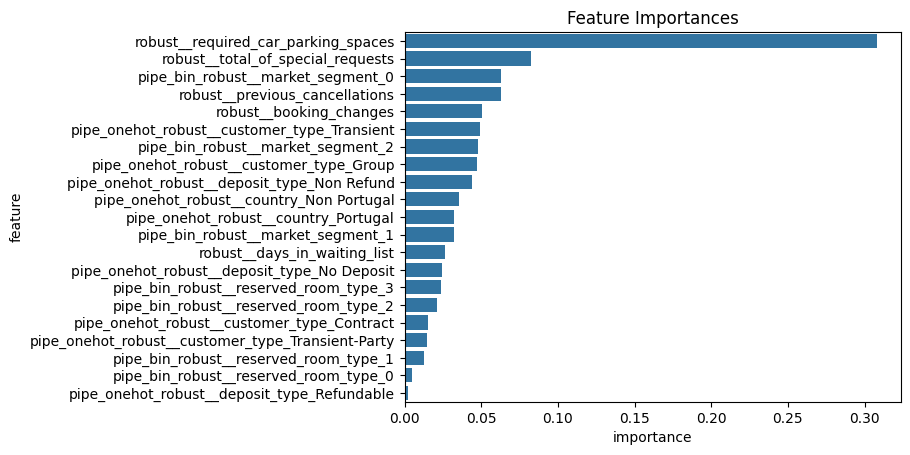

In [ ]:
importance = model_ada_tree.named_steps['modeling'].feature_importances_

feature_names = model_ada_tree.named_steps['preprocessing'].get_feature_names_out()

feature_importance = pd.DataFrame()
feature_importance['feature'] = feature_names
feature_importance['importance'] = importance
feature_importance = feature_importance.sort_values(
    'importance', ascending=False)

plt.title('Feature Importances')
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.show()

### Required Car Parking Spaces

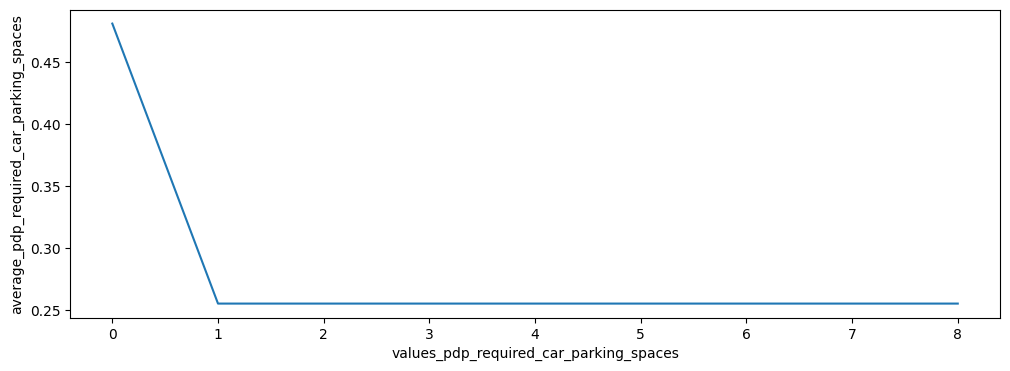

In [193]:
average_pdp_required_car_parking_spaces = partial_dependence(estimator=model_ada_tree, X=x_train, features=['required_car_parking_spaces'])['average'][0]
values_pdp_required_car_parking_spaces = partial_dependence(estimator=model_ada_tree, X=x_train, features=['required_car_parking_spaces'])['grid_values'][0]

df_pdp = pd.DataFrame({
    'values_pdp_required_car_parking_spaces': values_pdp_required_car_parking_spaces,
    'average_pdp_required_car_parking_spaces': average_pdp_required_car_parking_spaces
})

df_pdp.head()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_pdp, x='values_pdp_required_car_parking_spaces', y='average_pdp_required_car_parking_spaces');

`required_car_parking_spaces` --> Jumlah tempat parkir yang diminta oleh pelanggan.
- Kolom ini berada di posisi pertama, yang berarti kolom ini adalah kolom yang paling berpengaruh terhadap peluang untuk customer membatalkan pemesanan kamar hotel.
- Semakin sedikit jumlah tempat parkir kendaraan yang diminta oleh pelanggan, maka potensi customer melakukan pembatalan semakin besar.
- Hal tersebut mungkin karena kebanyakan customer menginginkan jumlah tempat parkir kendaraan yang lebih banyak. Sehingga customer yang memiliki jumlah tempat parkir yang lebih sedikit akan cenderung untuk membatalkan pemesanan, karena mungkin tidak sesuai dengan keinginan mereka yang menginginkan jumlah tempat parkir kendaraan yang lebih banyak.

### Total of Special Request

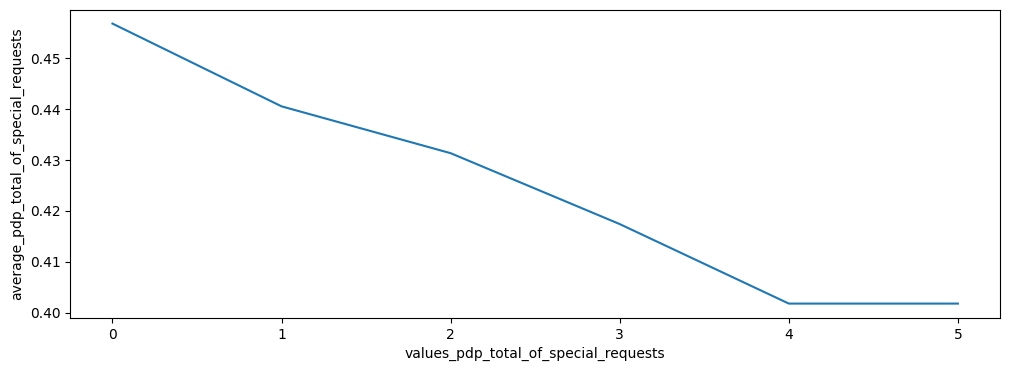

In [196]:
average_pdp_total_of_special_requests = partial_dependence(estimator=model_ada_tree, X=x_train, features=['total_of_special_requests'])['average'][0]
values_pdp_total_of_special_requests = partial_dependence(estimator=model_ada_tree, X=x_train, features=['total_of_special_requests'])['grid_values'][0]

df_pdp = pd.DataFrame({
    'values_pdp_total_of_special_requests': values_pdp_total_of_special_requests,
    'average_pdp_total_of_special_requests': average_pdp_total_of_special_requests
})

df_pdp.head()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_pdp, x='values_pdp_total_of_special_requests', y='average_pdp_total_of_special_requests');

`total_of_special_requests` --> Jumlah permintaan khusus dari pelanggan (misalnya tambahan bantal, kamar di lantai tertentu).
- Customer yang memiliki banyak permintaan khusus cenderung untuk tidak membatalkan pemesanan kamar.
- Semakin sedikit customer yang memiliki permintaan khusus, maka akan cenderung membatalkan pemesanan kamar.
- Kurang lebih sama seperti required car parking spaces, hal tersebut mungkin karena customer menginginkan jumlah permintaan yang lebih banyak untuk memenuhi keinginan mereka. Jika pihak hotel tidak bisa memenuhi jumlah permintaan khusus mereka, maka mereka akan membatalkan pemesanan, dan mungkin akan memilih hotel lain.

### Previous Cancellations

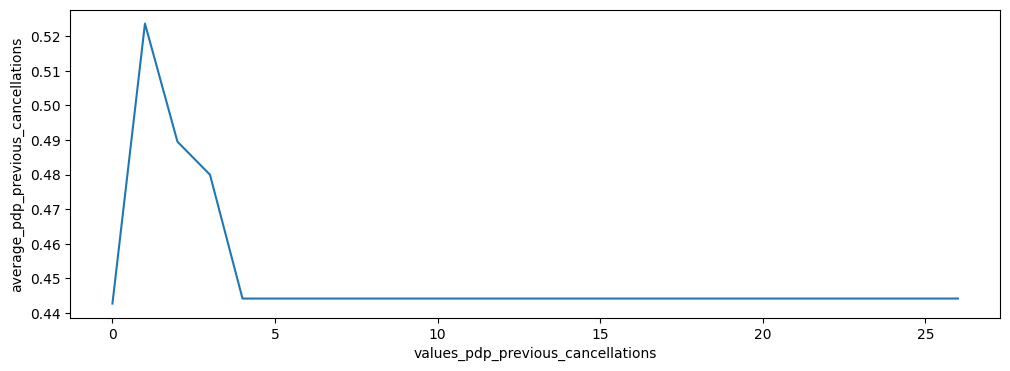

In [205]:
average_pdp_previous_cancellations = partial_dependence(estimator=model_ada_tree, X=x_train, features=['previous_cancellations'])['average'][0]
values_pdp_previous_cancellations = partial_dependence(estimator=model_ada_tree, X=x_train, features=['previous_cancellations'])['grid_values'][0]

df_pdp = pd.DataFrame({
    'values_pdp_previous_cancellations': values_pdp_previous_cancellations,
    'average_pdp_previous_cancellations': average_pdp_previous_cancellations
})

df_pdp.head()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_pdp, x='values_pdp_previous_cancellations', y='average_pdp_previous_cancellations');

`previous_cancellations` --> Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini.
- Customer yang memiliki jumlah pemesanan sebelumnya yang dibatalkan lebih banyak justru cenderung untuk tidak membatalkan pemesanan. 
- Karena customer yang sudah melakukan banyak pembatalan sebelum pemesanan ini sudah menemukan kamar yang sesuai dengan keinginan mereka
- Analoginya customer tersebut membatalkan pemesanan, 

## **Conclusion**
- 